In [198]:
import pandas as pd
import numpy as np

In [199]:
df1 = pd.read_csv('data/Postings_01052019_15052019.csv', sep=';')

In [200]:
df1.shape

(343160, 14)

In [201]:
df2 = pd.read_csv('data/Postings_16052019_31052019.csv', sep=';')

In [202]:
df2.shape

(395934, 14)

In [203]:
df = pd.concat([df1, df2], ignore_index=True)
df.shape


(739094, 14)

In [204]:
df.head()

ID_Posting  ID_Posting_Parent  ID_CommunityIdentity  \
0  1041073586       1.041073e+09                671476   
1  1041073839       1.041073e+09                566938   
2  1041073872       1.041069e+09                669286   
3  1041080734       1.041080e+09                671476   
4  1041080828                NaN                671476   

                                     PostingHeadline  \
0  Das hat gestern bereits der Voggenhuber angefü...   
1                                                NaN   
2                                                NaN   
3                  Sie haben doch nichts gefordert??   
4  Heute wäre der perfekte Tag für die SPÖ gewese...   

                                      PostingComment         PostingCreatedAt  \
0  schieder hatte dem inhaltlich nichts entgegenz...  2019-05-01 18:21:15.127   
1     ...und meinen Bezirk bekommst du als Erbe mit.  2019-05-01 18:28:22.040   
2  Nein, bei der ÖVP/FPÖ genauso passiert. Ich wo...  2019-05-01 18:29:05.533   
3  sie haben nur die regierung kritisiert. das di...  2019-05-01 22:37:56.010   
4  ihr noch nicht erfülltes versprechen, den silb...  2019-05-01 22:42:06.310   

      ID_Article   ArticlePublishingDate  \
0  2000102330973  2019-05-01 10:28:57.49   
1  2000102330973  2019-05-01 10:28:57.49   
2  2000102330973  2019-05-01 10:28:57.49   
3  2000102330973  2019-05-01 10:28:57.49   
4  2000102330973  2019-05-01 10:28:57.49   

                                        ArticleTitle ArticleChannel  \
0  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland   
1  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland   
2  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland   
3  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland   
4  1. Mai in Wien: SPÖ fordert von Strache Rücktritt         Inland   

  ArticleRessortName UserCommunityName UserGender            UserCreatedAt  
0           Parteien       Ravenspower        NaN  2018-04-14 13:42:28.470  
1           Parteien        AlphaRomeo          m  2015-08-28 17:07:41.110  
2           Parteien        Hpolditsch        NaN  2018-03-06 20:03:42.737  
3           Parteien       Ravenspower        NaN  2018-04-14 13:42:28.470  
4           Parteien       Ravenspower        NaN  2018-04-14 13:42:28.470

In [205]:
df = df[['ID_CommunityIdentity', 'ID_Posting', 'ID_Posting_Parent']]

comment_user_mapping = df[['ID_Posting', 'ID_CommunityIdentity']].drop_duplicates().rename(columns={'ID_Posting':'Id_posting', 'ID_CommunityIdentity': 'ID_ParentIdentity'})

result_df = pd.merge(df, comment_user_mapping, left_on='ID_Posting_Parent', right_on='Id_posting', how='left')
result_df = result_df[['ID_CommunityIdentity', 'ID_ParentIdentity']]
result_df.head()

ID_CommunityIdentity  ID_ParentIdentity
0                671476           233191.0
1                566938           640123.0
2                669286           680772.0
3                671476            51817.0
4                671476                NaN

In [206]:
reply_counts = result_df.groupby(['ID_CommunityIdentity', 'ID_ParentIdentity']).size().reset_index(name='counts')

reply_counts = reply_counts[:500]

In [207]:
import networkx as nx

In [208]:
G = nx.from_pandas_edgelist(reply_counts, 
                            source='ID_CommunityIdentity', 
                            target='ID_ParentIdentity', 
                            edge_attr = 'counts',
                            create_using=nx.Graph())

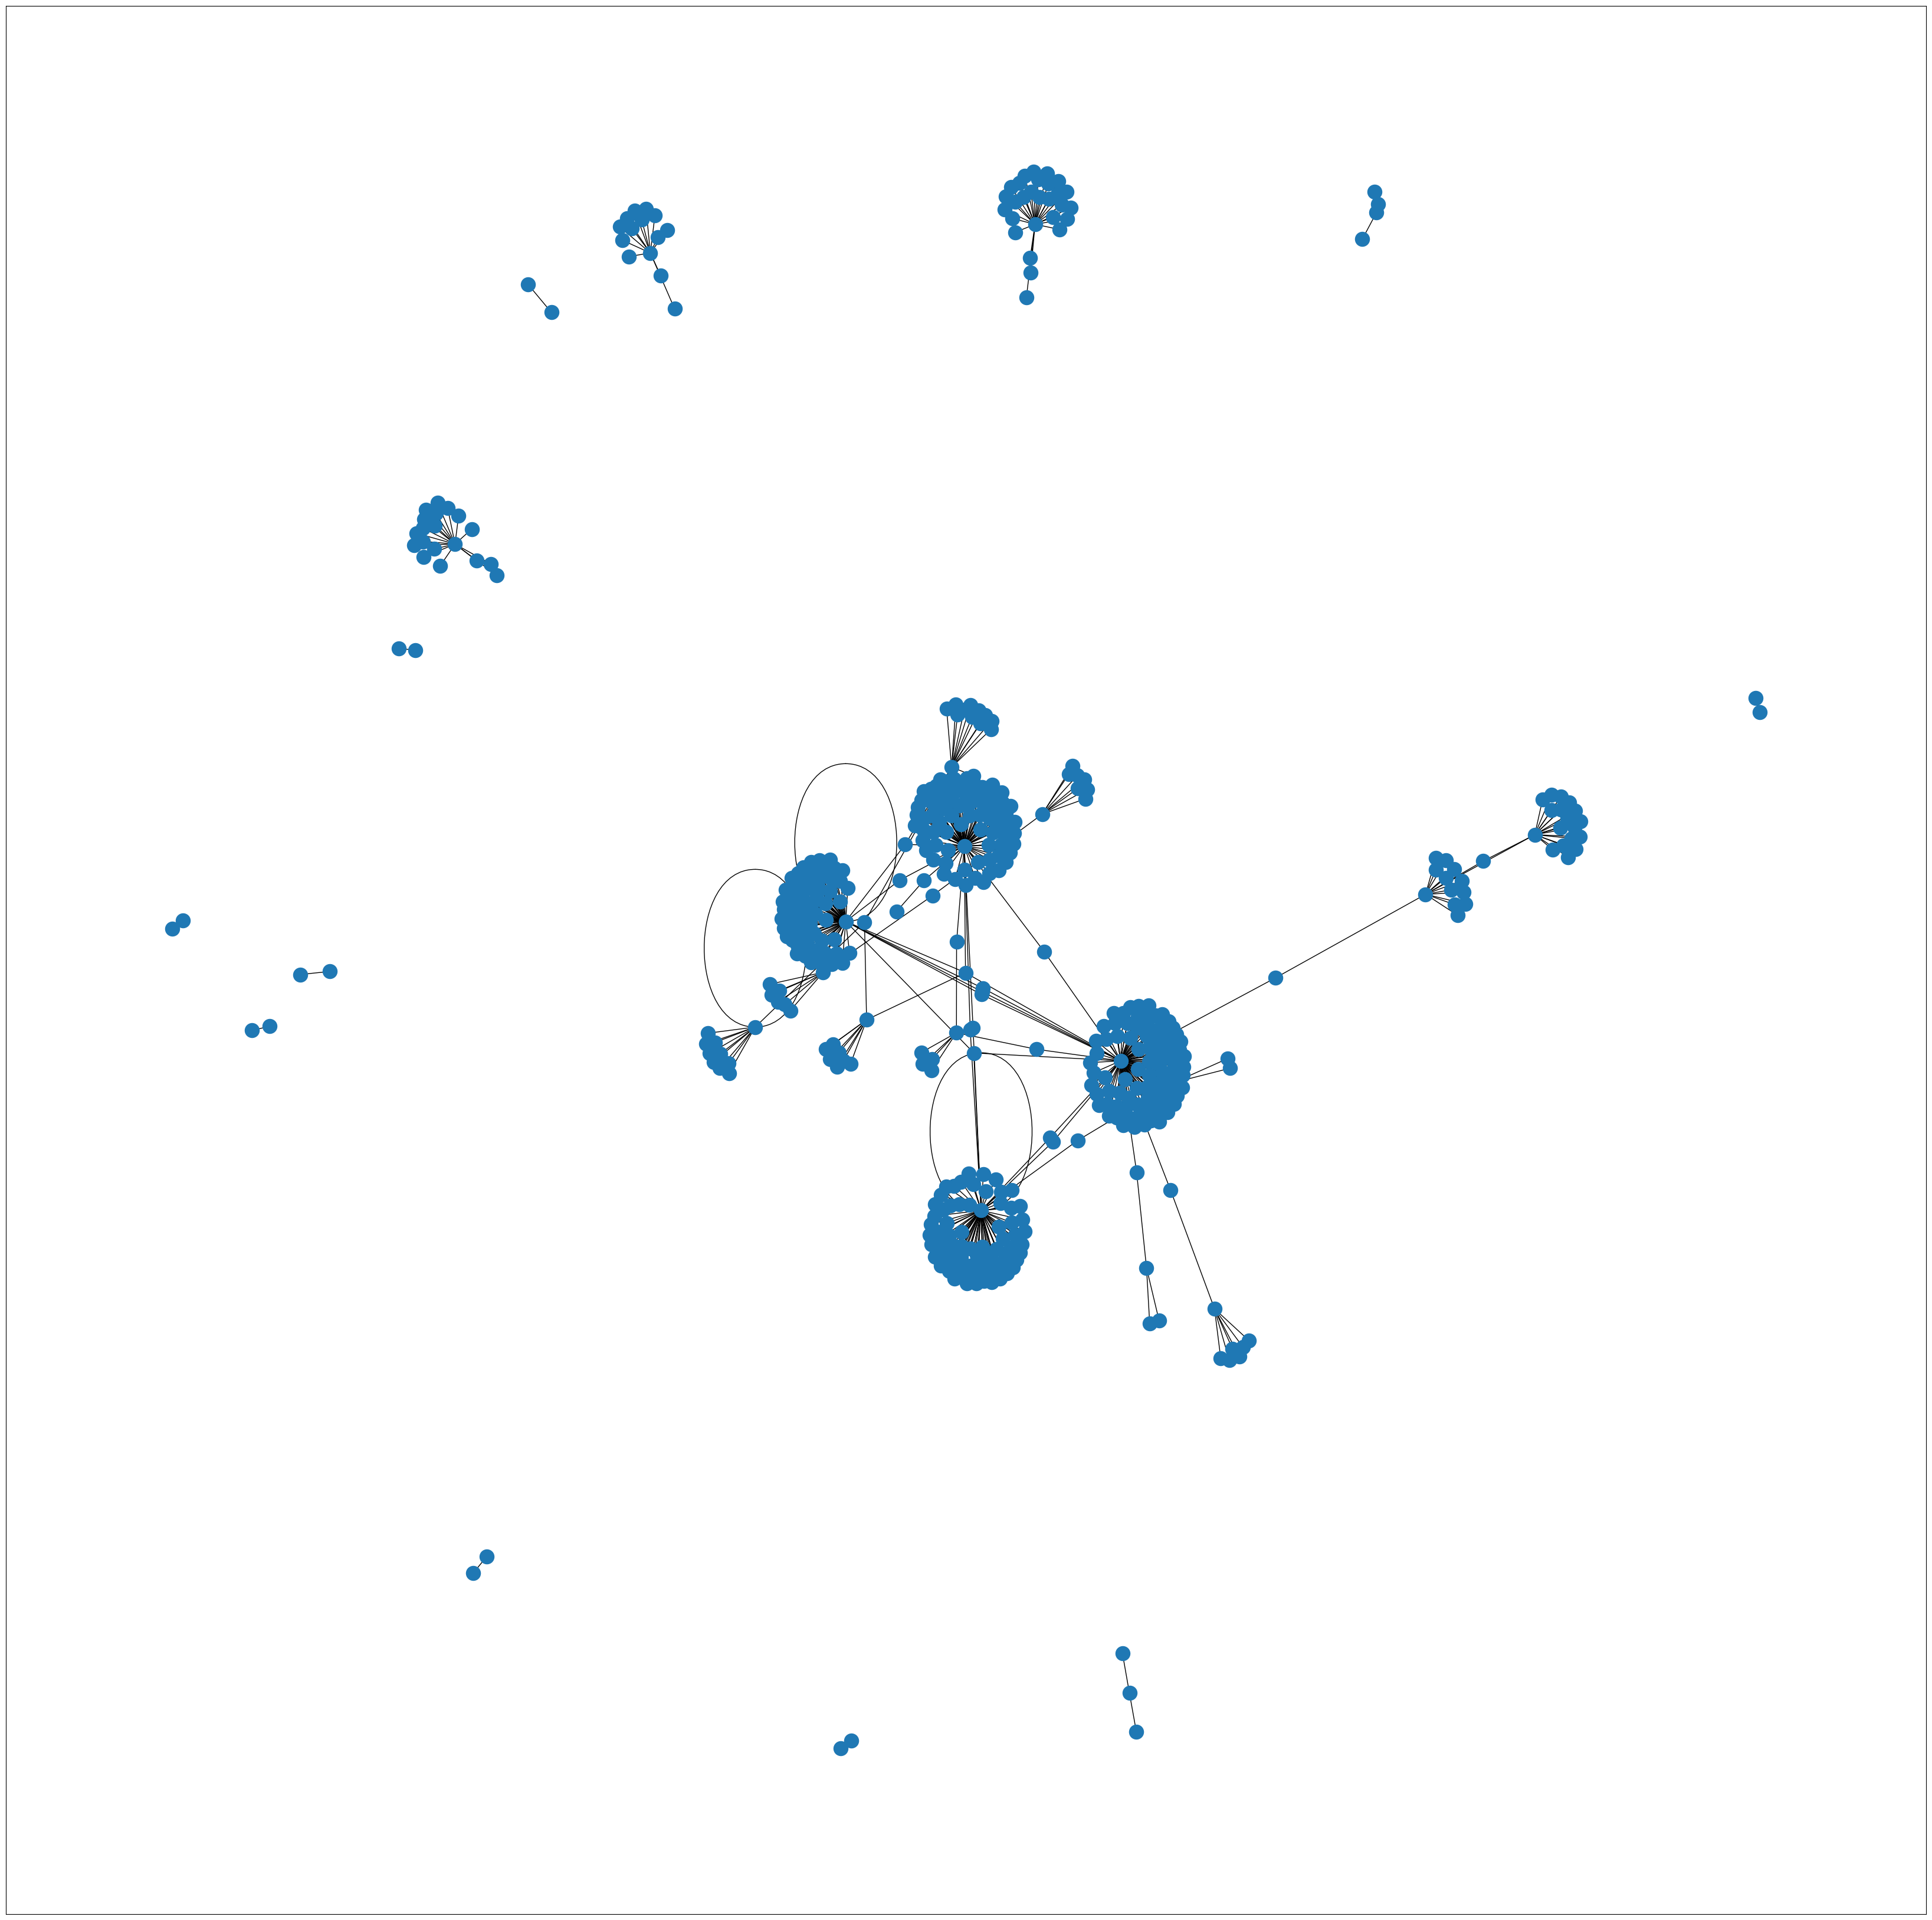

In [209]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(42,42))
nx.draw_networkx(G, with_labels=False)
plt.show()

In [210]:
adj_matrix = nx.to_numpy_array(G, dtype=int)

print("Adjacency Matrix:")
print(adj_matrix)

Adjacency Matrix:
[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [211]:
def find_equivalent_nodes(graph):
    grouped_nodes = set()
    equivalent_nodes = []
    for node in graph.nodes():
        if node not in grouped_nodes:
            equivalent = [node]
            grouped_nodes.add(node)
            for other_node in graph.nodes():
                if other_node not in grouped_nodes and node != other_node and set(graph.neighbors(node)) == set(graph.neighbors(other_node)):
                    equivalent.append(other_node)
                    grouped_nodes.add(other_node)
            if len(equivalent) > 1:
                equivalent_nodes.append(equivalent)
    return equivalent_nodes

In [212]:
# equivalent_nodes = find_equivalent_nodes(G)

# color_map = {}
# for i, nodes in enumerate(equivalent_nodes):
#     for node in nodes:
#         color_map[node] = i

# # Visualize the graph with nodes colored by groups
# pos = nx.spring_layout(G)  # Positions of nodes for visualization
# nx.draw(G, pos, node_color=[color_map[node] for node in G.nodes()], with_labels=True, cmap=plt.cm.tab10)
# plt.title('Graph with Nodes Colored by Equivalent Groups')
# plt.show()

In [213]:
import networkx as nx
import matplotlib.pyplot as plt

def find_equivalent_nodes(graph):
    grouped_nodes = set()
    equivalent_nodes = []
    for node in graph.nodes():
        if node not in grouped_nodes:
            equivalent = [node]
            grouped_nodes.add(node)
            for other_node in graph.nodes():
                if other_node not in grouped_nodes and node != other_node and set(graph.neighbors(node)) == set(graph.neighbors(other_node)):
                    equivalent.append(other_node)
                    grouped_nodes.add(other_node)
            if len(equivalent) > 1:
                equivalent_nodes.append(equivalent)
    return equivalent_nodes


# Find equivalent nodes based on regular equivalence
equivalent_nodes = find_equivalent_nodes(G)

# Create a color map for nodes based on groups
color_map = {}
for i, nodes in enumerate(equivalent_nodes):
    for node in nodes:
        color_map[node] = i

# Assign a default color for nodes not in any group
default_color = len(equivalent_nodes)  # Assign a unique color for nodes not in any group
for node in G.nodes():
    if node not in color_map:
        color_map[node] = default_color


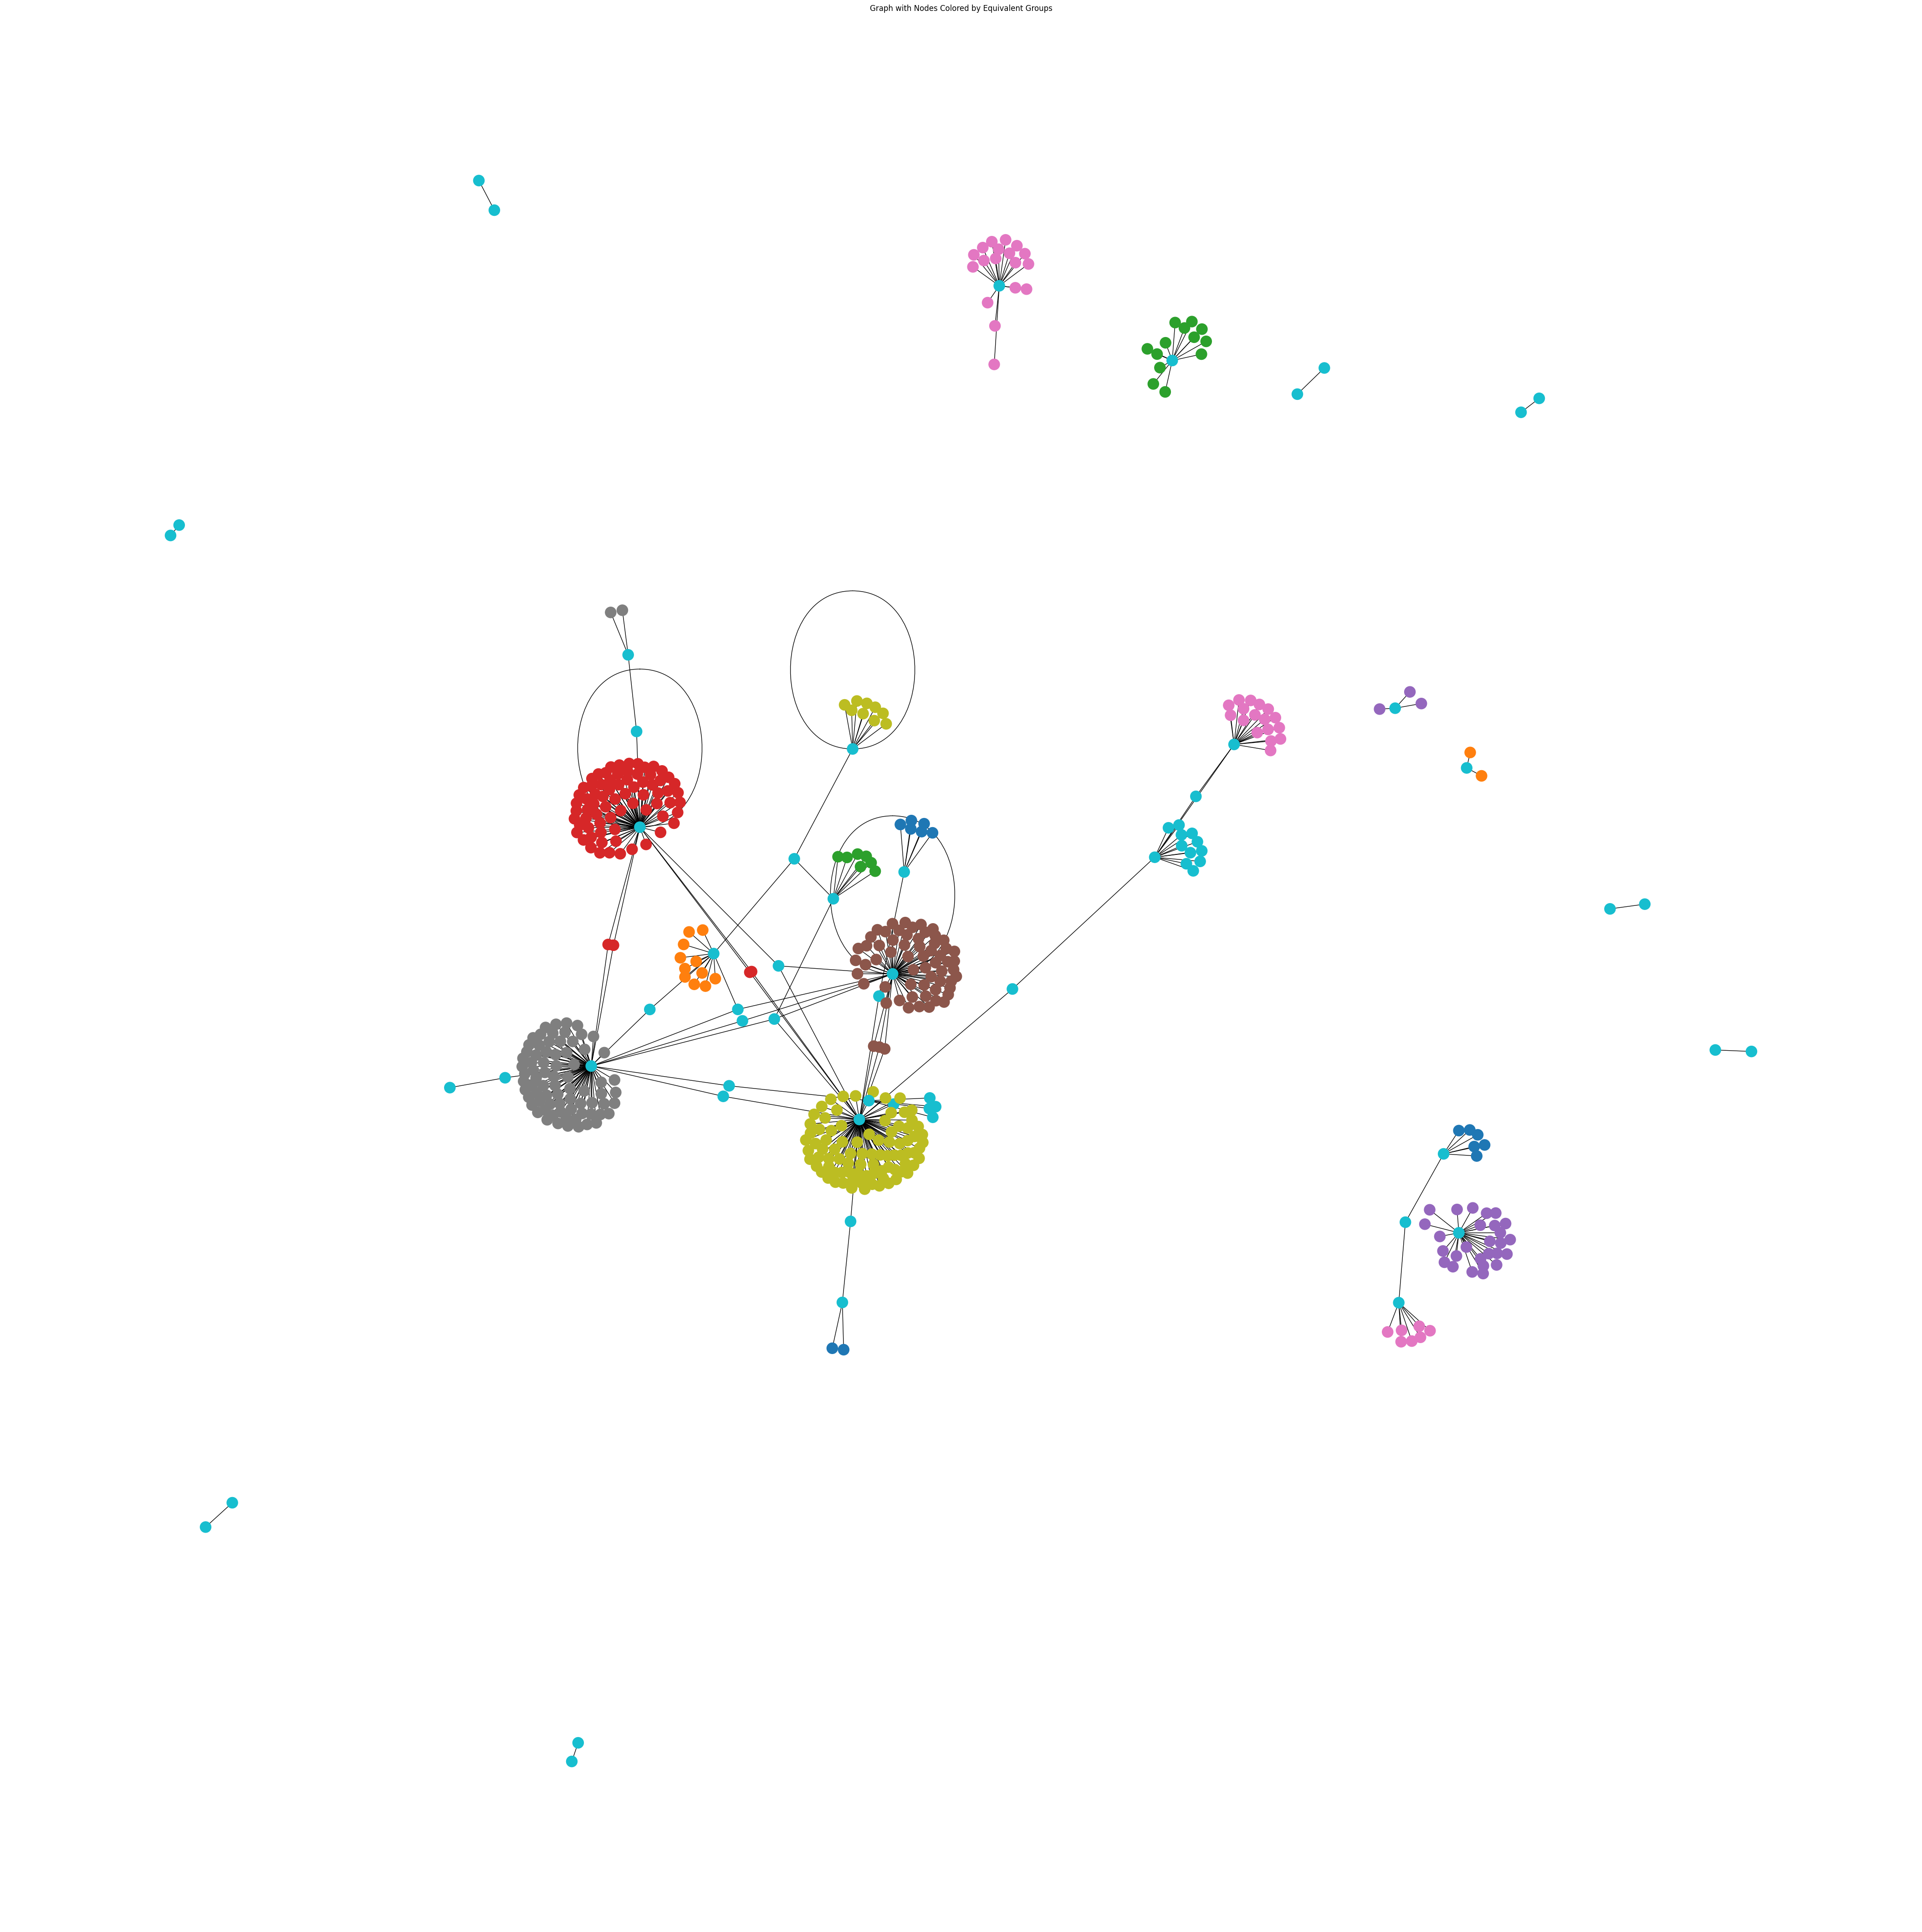

In [214]:
plt.figure(figsize=(42, 42))

# Visualize the graph with nodes colored by groups
pos = nx.spring_layout(G)  # Positions of nodes for visualization
node_colors = [color_map[node] for node in G.nodes()]
nx.draw(G, pos, node_color=node_colors, with_labels=False, cmap=plt.cm.tab10)
plt.title('Graph with Nodes Colored by Equivalent Groups')
plt.show()


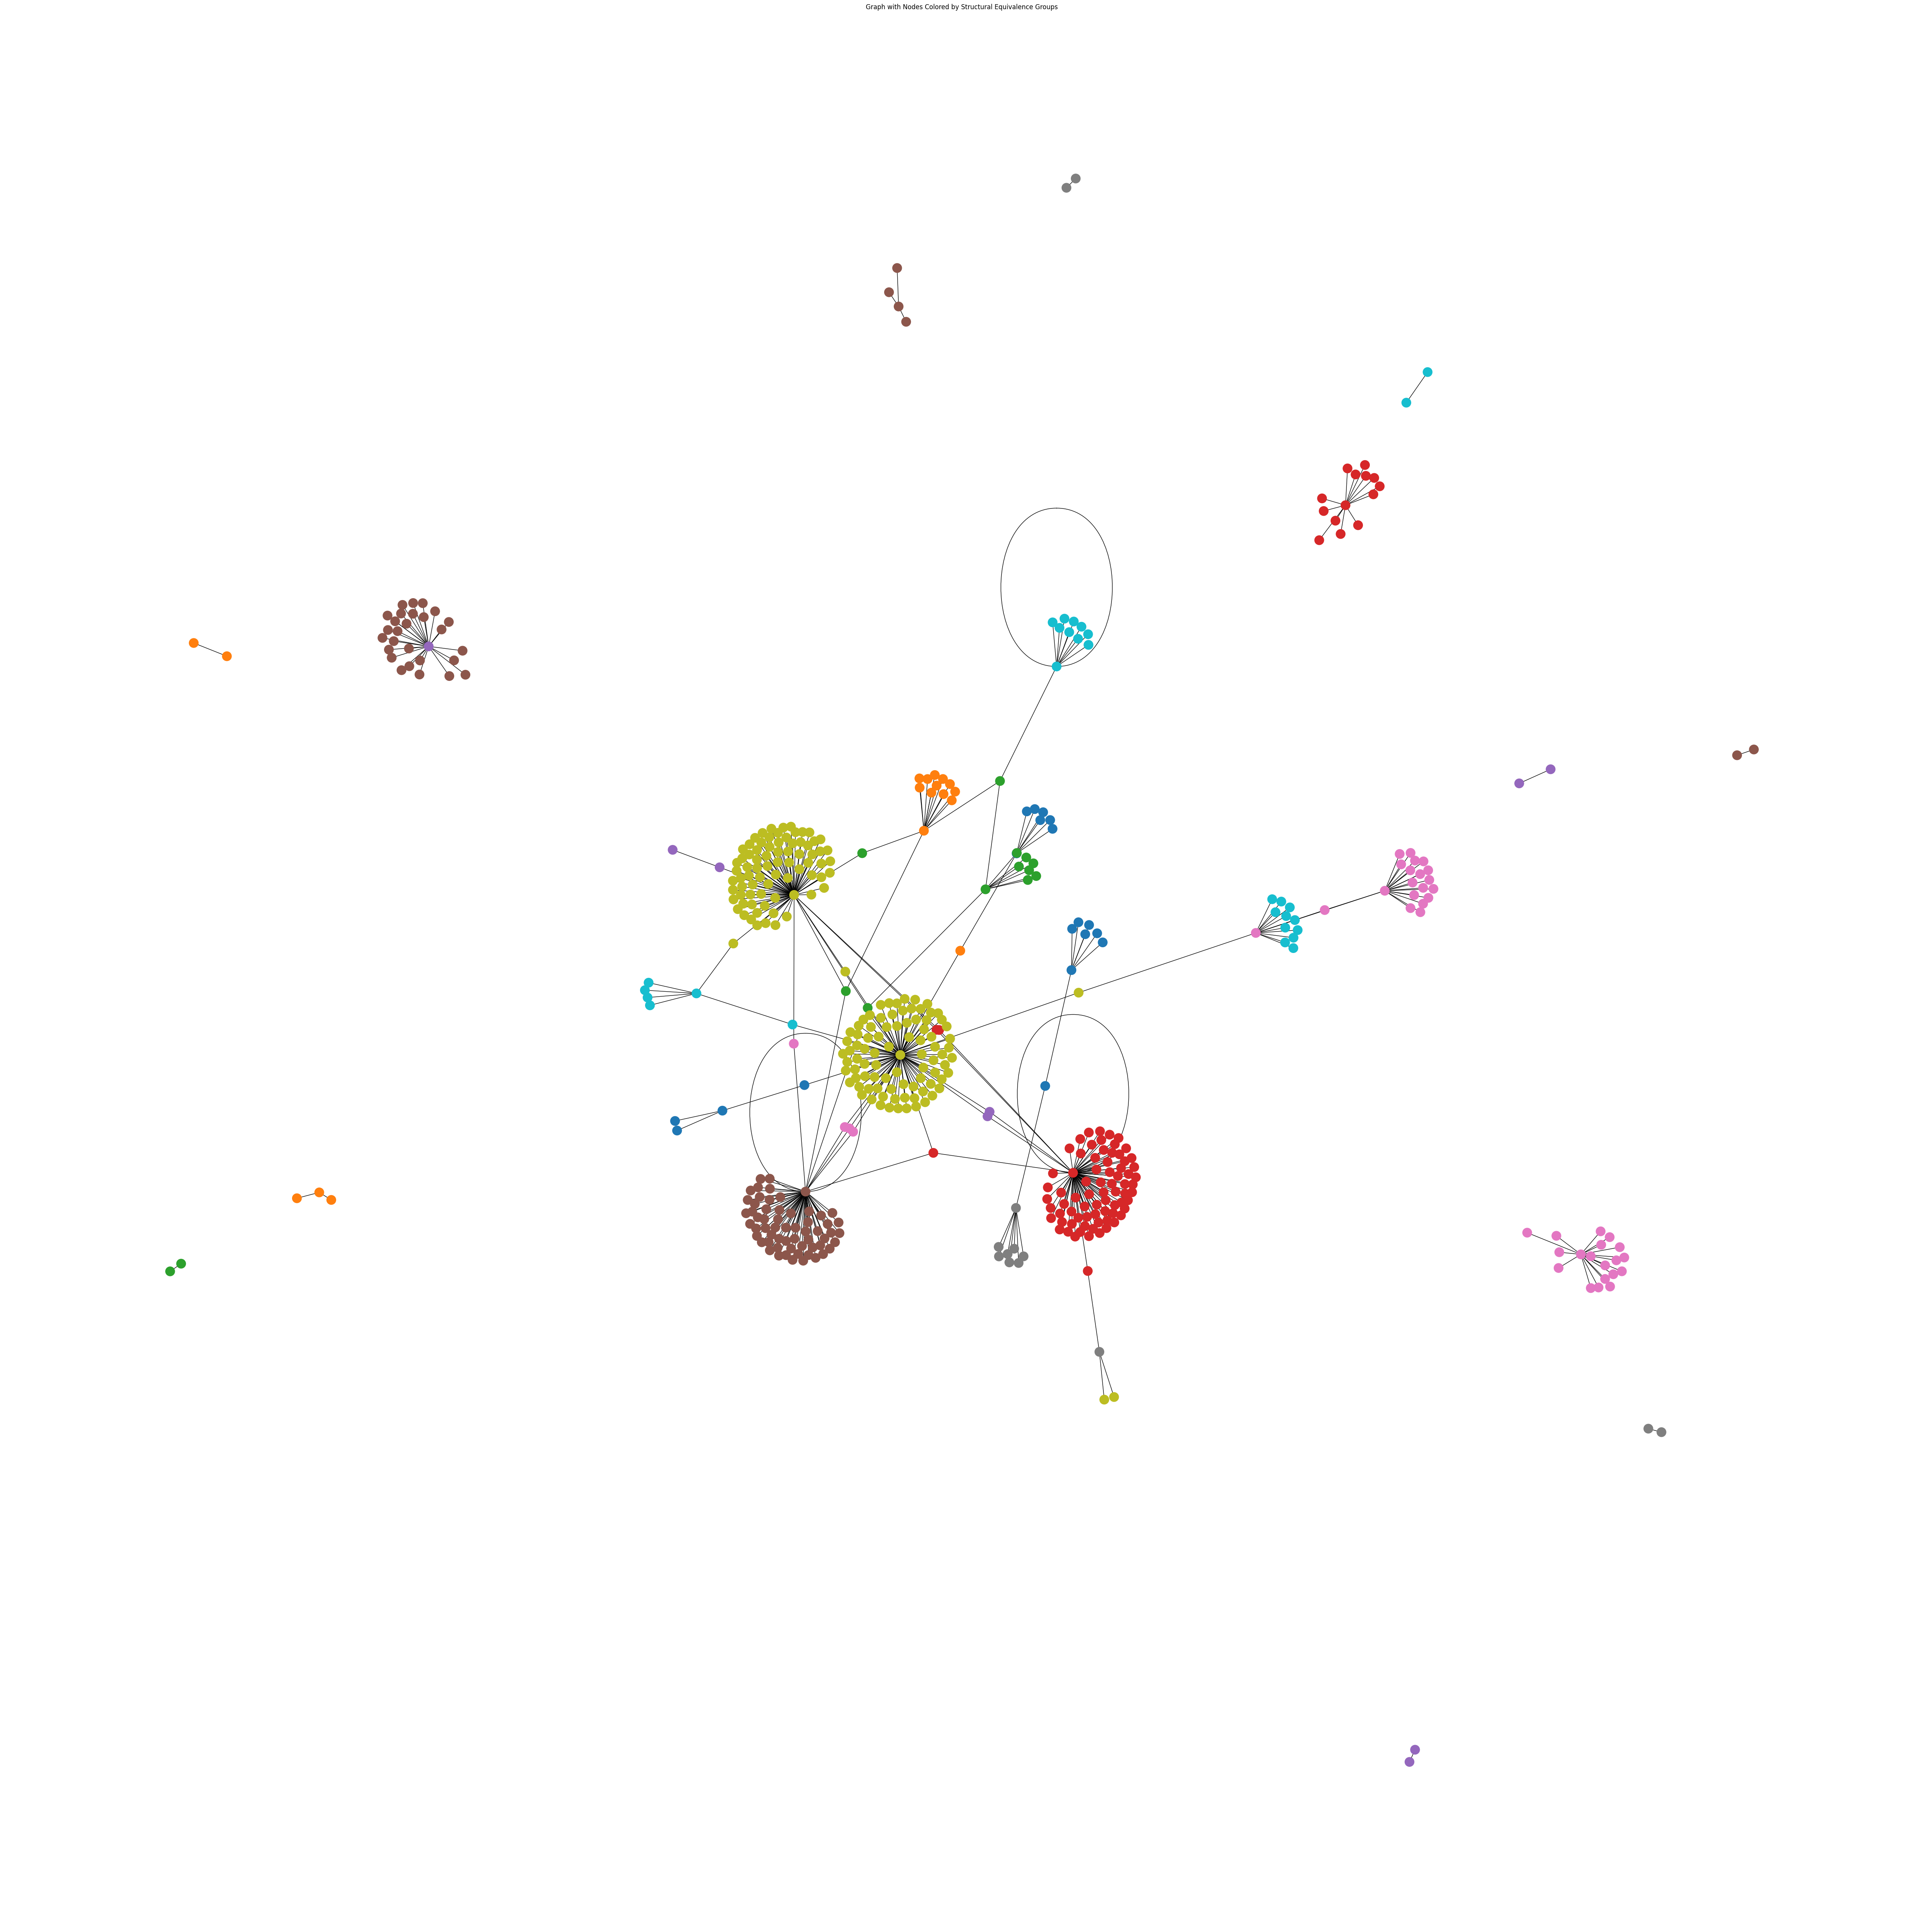

In [215]:
import networkx as nx
import matplotlib.pyplot as plt

def find_structurally_equivalent_nodes(graph):
    structurally_equivalent = []
    nodes = list(graph.nodes())
    while nodes:
        node = nodes[0]
        structurally_equivalent.append([node])
        neighbors = set(graph.neighbors(node))
        nodes.remove(node)
        i = 0
        while i < len(structurally_equivalent[-1]):
            curr_node = structurally_equivalent[-1][i]
            curr_neighbors = set(graph.neighbors(curr_node))
            for n in nodes[:]:
                if curr_neighbors == set(graph.neighbors(n)):
                    structurally_equivalent[-1].append(n)
                    nodes.remove(n)
            i += 1
    return structurally_equivalent

# Find structurally equivalent nodes
structurally_equivalent_nodes = find_structurally_equivalent_nodes(G)

# Create a color map for nodes based on structural equivalence groups
color_map = {}
for i, nodes in enumerate(structurally_equivalent_nodes):
    for node in nodes:
        color_map[node] = i

# Assign a default color for nodes not in any group
default_color = len(structurally_equivalent_nodes)
for node in G.nodes():
    if node not in color_map:
        color_map[node] = default_color

# Positions of nodes for visualization
pos = nx.spring_layout(G, seed=42)  # Positions of nodes for visualization

# Set figure size
plt.figure(figsize=(50, 50))

# Draw the graph with nodes colored by structural equivalence groups
node_colors = [color_map[node] for node in G.nodes()]
nx.draw(G, pos, node_color=node_colors, with_labels=False, cmap=plt.cm.tab10)
plt.title('Graph with Nodes Colored by Structural Equivalence Groups')
plt.show()


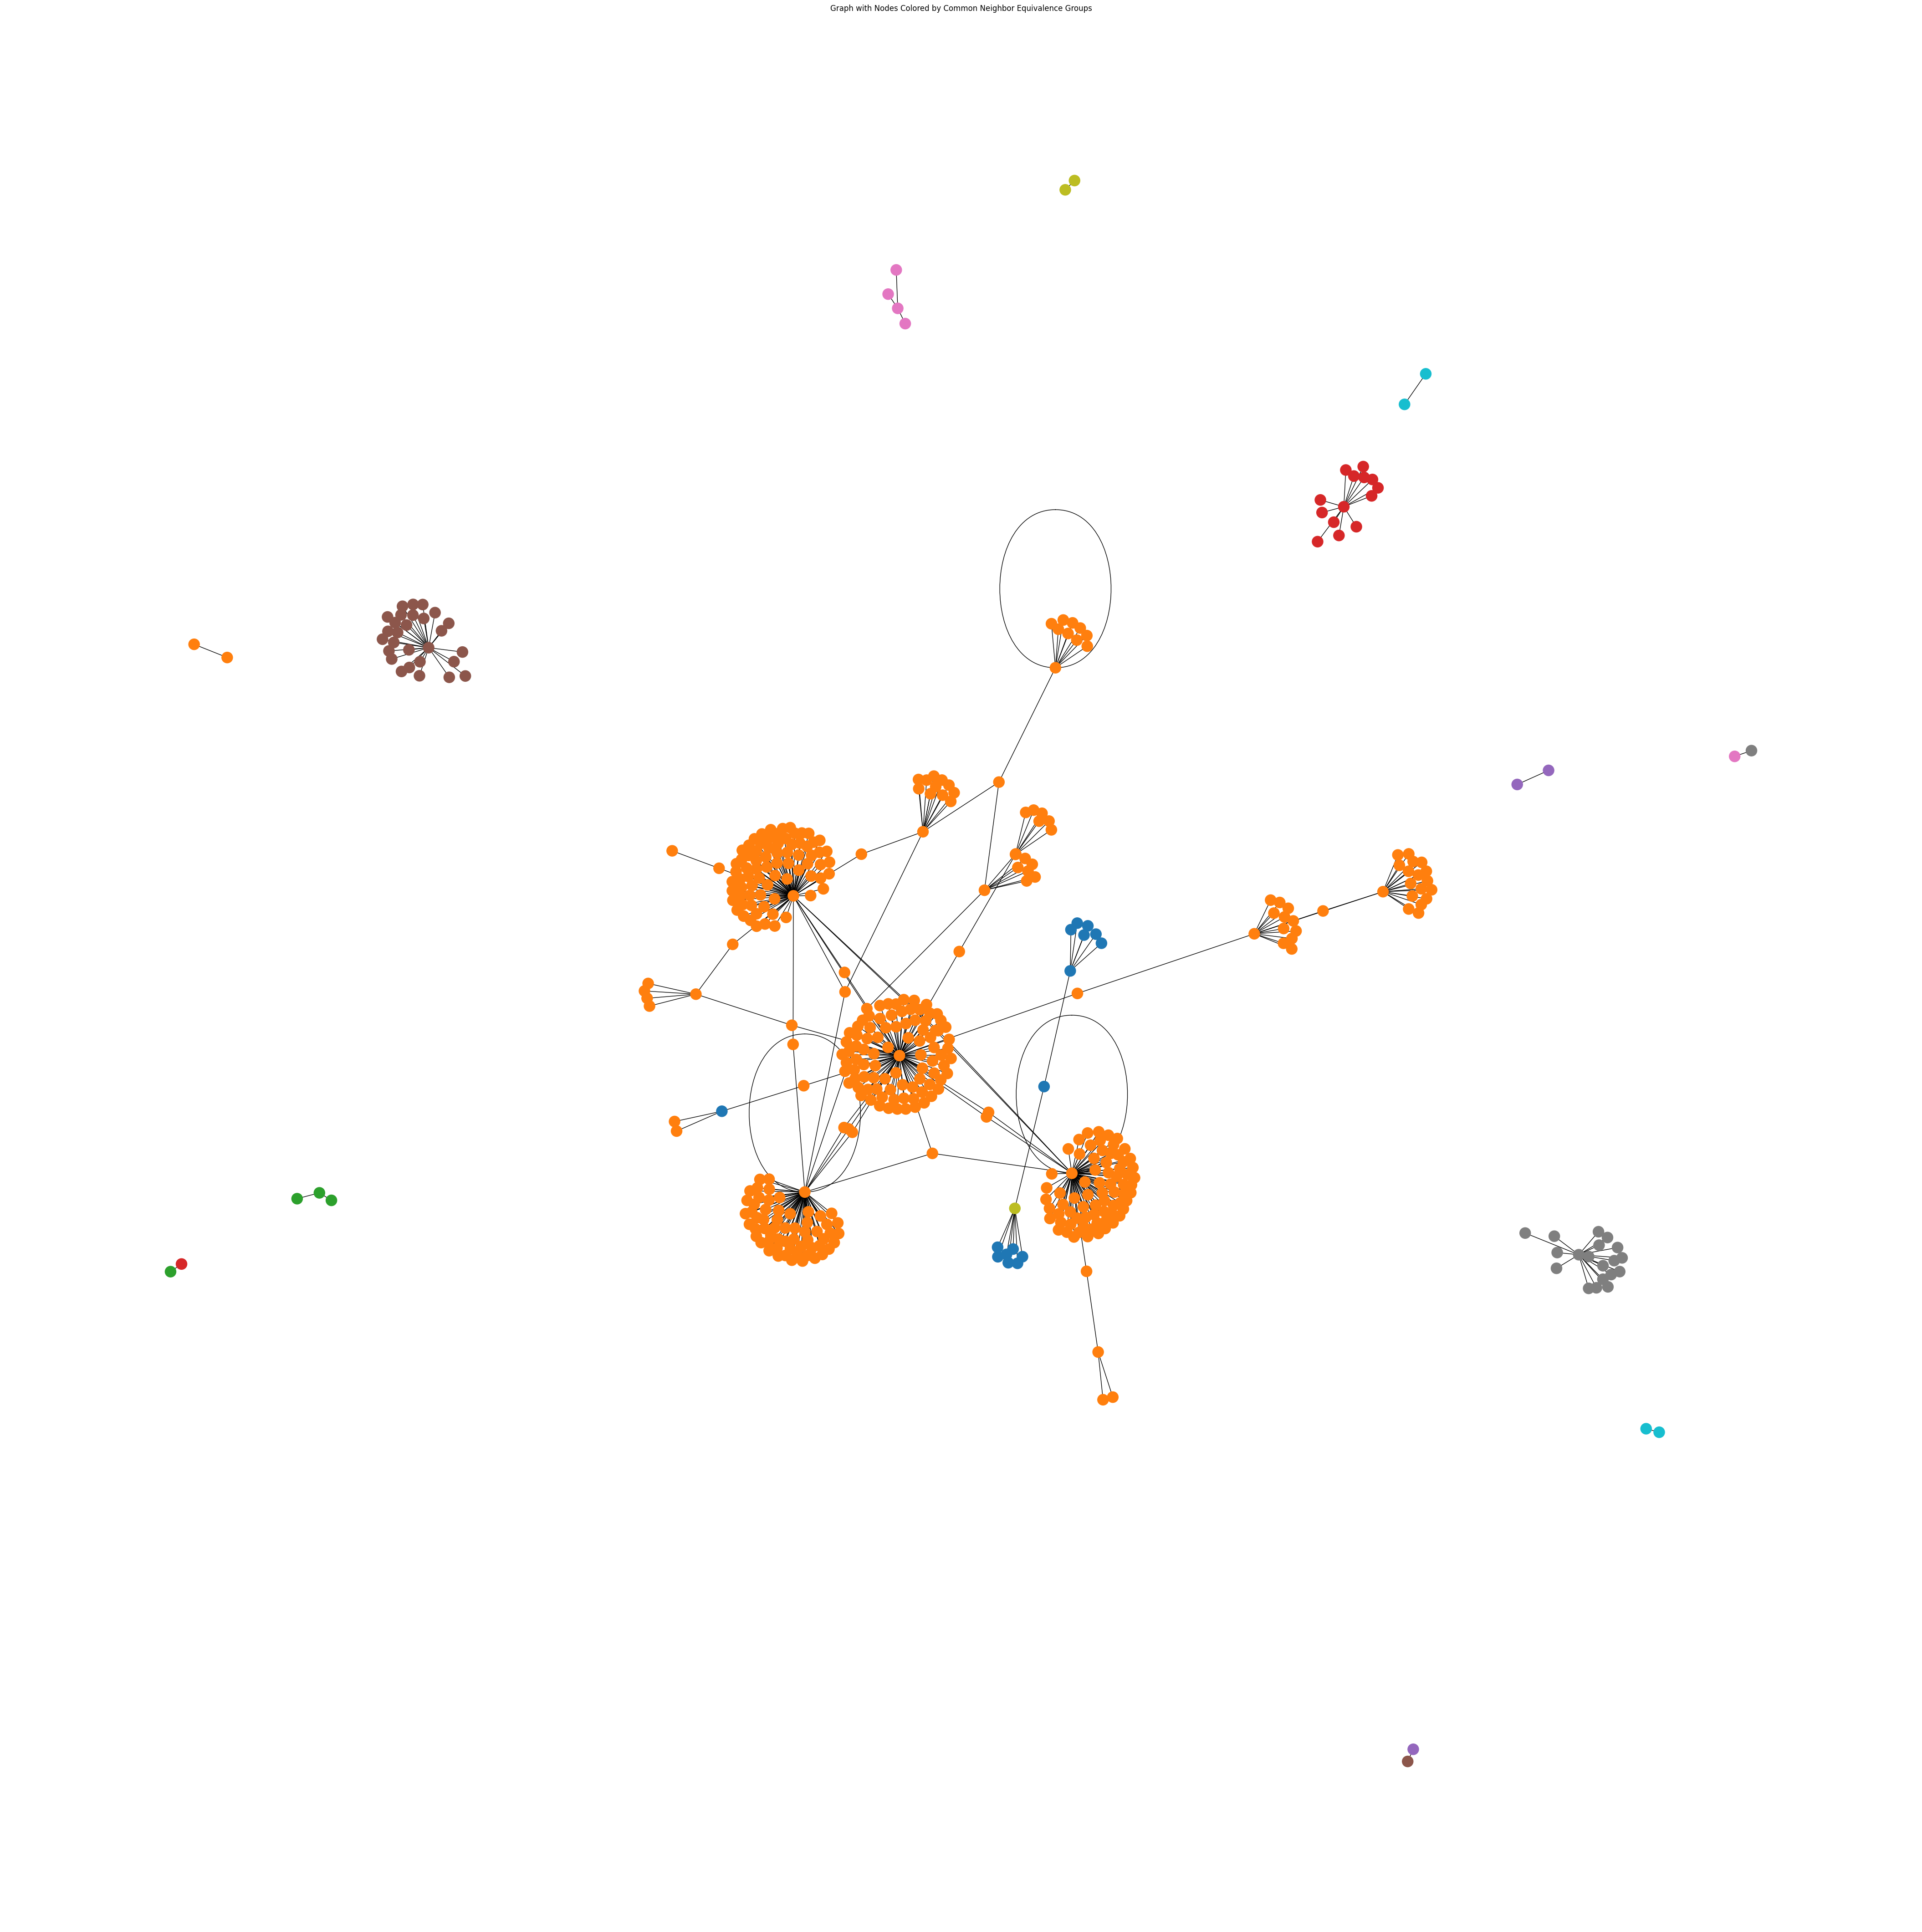

In [216]:
def find_common_neighbor_equivalent_nodes(graph):
    equivalent = []
    nodes = list(graph.nodes())
    while nodes:
        node = nodes[0]
        equivalent.append([node])
        neighbors = set(graph.neighbors(node))
        nodes.remove(node)
        i = 0
        while i < len(equivalent[-1]):
            curr_node = equivalent[-1][i]
            curr_neighbors = set(graph.neighbors(curr_node))
            for n in nodes[:]:
                if len(curr_neighbors.intersection(set(graph.neighbors(n)))) == len(neighbors):
                    equivalent[-1].append(n)
                    nodes.remove(n)
            i += 1
    return equivalent

# Find nodes with common neighbor equivalence
common_neighbor_equivalent_nodes = find_common_neighbor_equivalent_nodes(G)

# Create a color map for nodes based on common neighbor equivalence groups
color_map_common = {}
for i, nodes in enumerate(common_neighbor_equivalent_nodes):
    for node in nodes:
        color_map_common[node] = i

# Assign a default color for nodes not in any group
default_color_common = len(common_neighbor_equivalent_nodes)
for node in G.nodes():
    if node not in color_map_common:
        color_map_common[node] = default_color_common

# Positions of nodes for visualization
pos_common = nx.spring_layout(G, seed=42)  # Positions of nodes for visualization

# Draw the graph with nodes colored by common neighbor equivalence groups
plt.figure(figsize=(42, 42))
node_colors_common = [color_map_common[node] for node in G.nodes()]
nx.draw(G, pos_common, node_color=node_colors_common, with_labels=False, cmap=plt.cm.tab10)
plt.title('Graph with Nodes Colored by Common Neighbor Equivalence Groups')
plt.show()


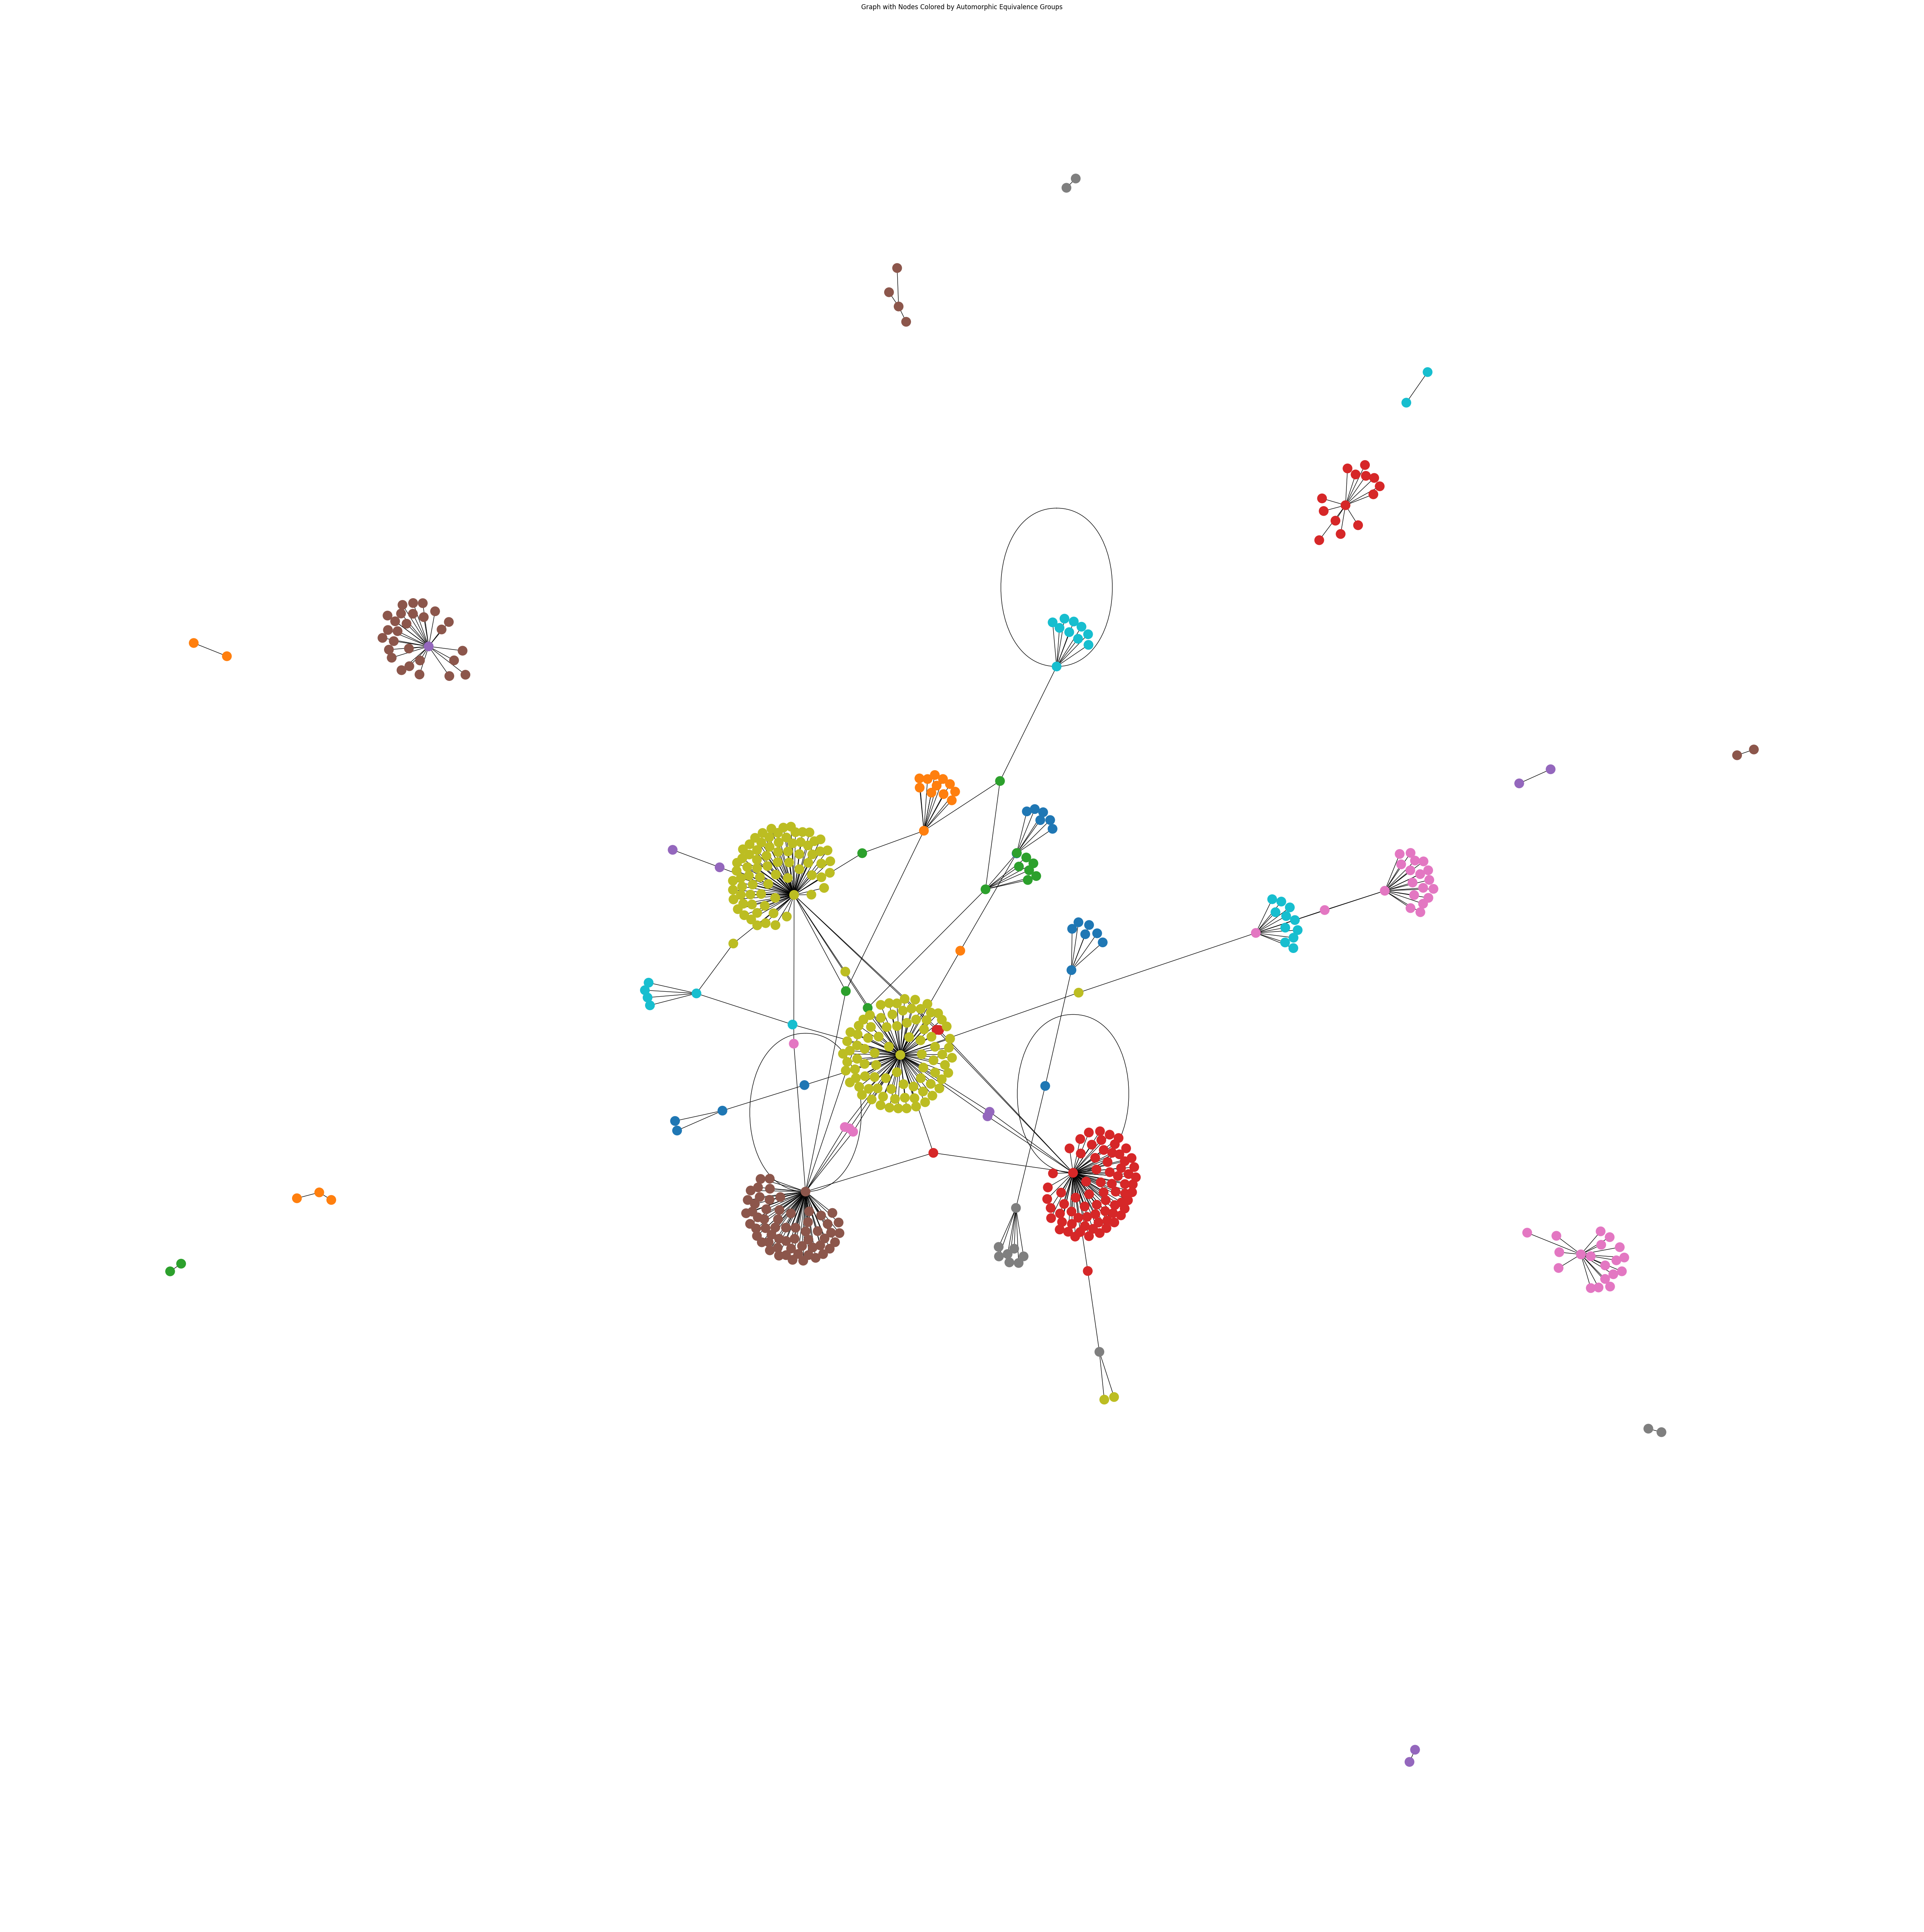

In [217]:
import networkx as nx
import matplotlib.pyplot as plt


def find_automorphic_equivalent_nodes(graph):
    automorphic_equivalent = []
    nodes = list(graph.nodes())
    while nodes:
        node = nodes[0]
        automorphic_equivalent.append([node])
        neighbors = sorted(set(graph.neighbors(node)))
        nodes.remove(node)
        i = 0
        while i < len(automorphic_equivalent[-1]):
            curr_node = automorphic_equivalent[-1][i]
            for n in nodes[:]:
                if neighbors == sorted(set(graph.neighbors(n))):
                    automorphic_equivalent[-1].append(n)
                    nodes.remove(n)
            i += 1
    return automorphic_equivalent

# Find automorphically equivalent nodes
automorphic_equivalent_nodes = find_automorphically_equivalent_nodes(G)

# Create a color map for nodes based on automorphic equivalence groups
color_map = {}
for i, nodes in enumerate(automorphic_equivalent_nodes):
    for node in nodes:
        color_map[node] = i

# Assign a default color for nodes not in any group
default_color = len(automorphic_equivalent_nodes)
for node in G.nodes():
    if node not in color_map:
        color_map[node] = default_color

# Positions of nodes for visualization
pos = nx.spring_layout(G, seed=42)  # Positions of nodes for visualization

# Set figure size
plt.figure(figsize=(50, 50))

# Draw the graph with nodes colored by automorphic equivalence groups
node_colors = [color_map[node] for node in G.nodes()]
nx.draw(G, pos, node_color=node_colors, with_labels=False, cmap=plt.cm.tab10)
plt.title('Graph with Nodes Colored by Automorphic Equivalence Groups')
plt.show()


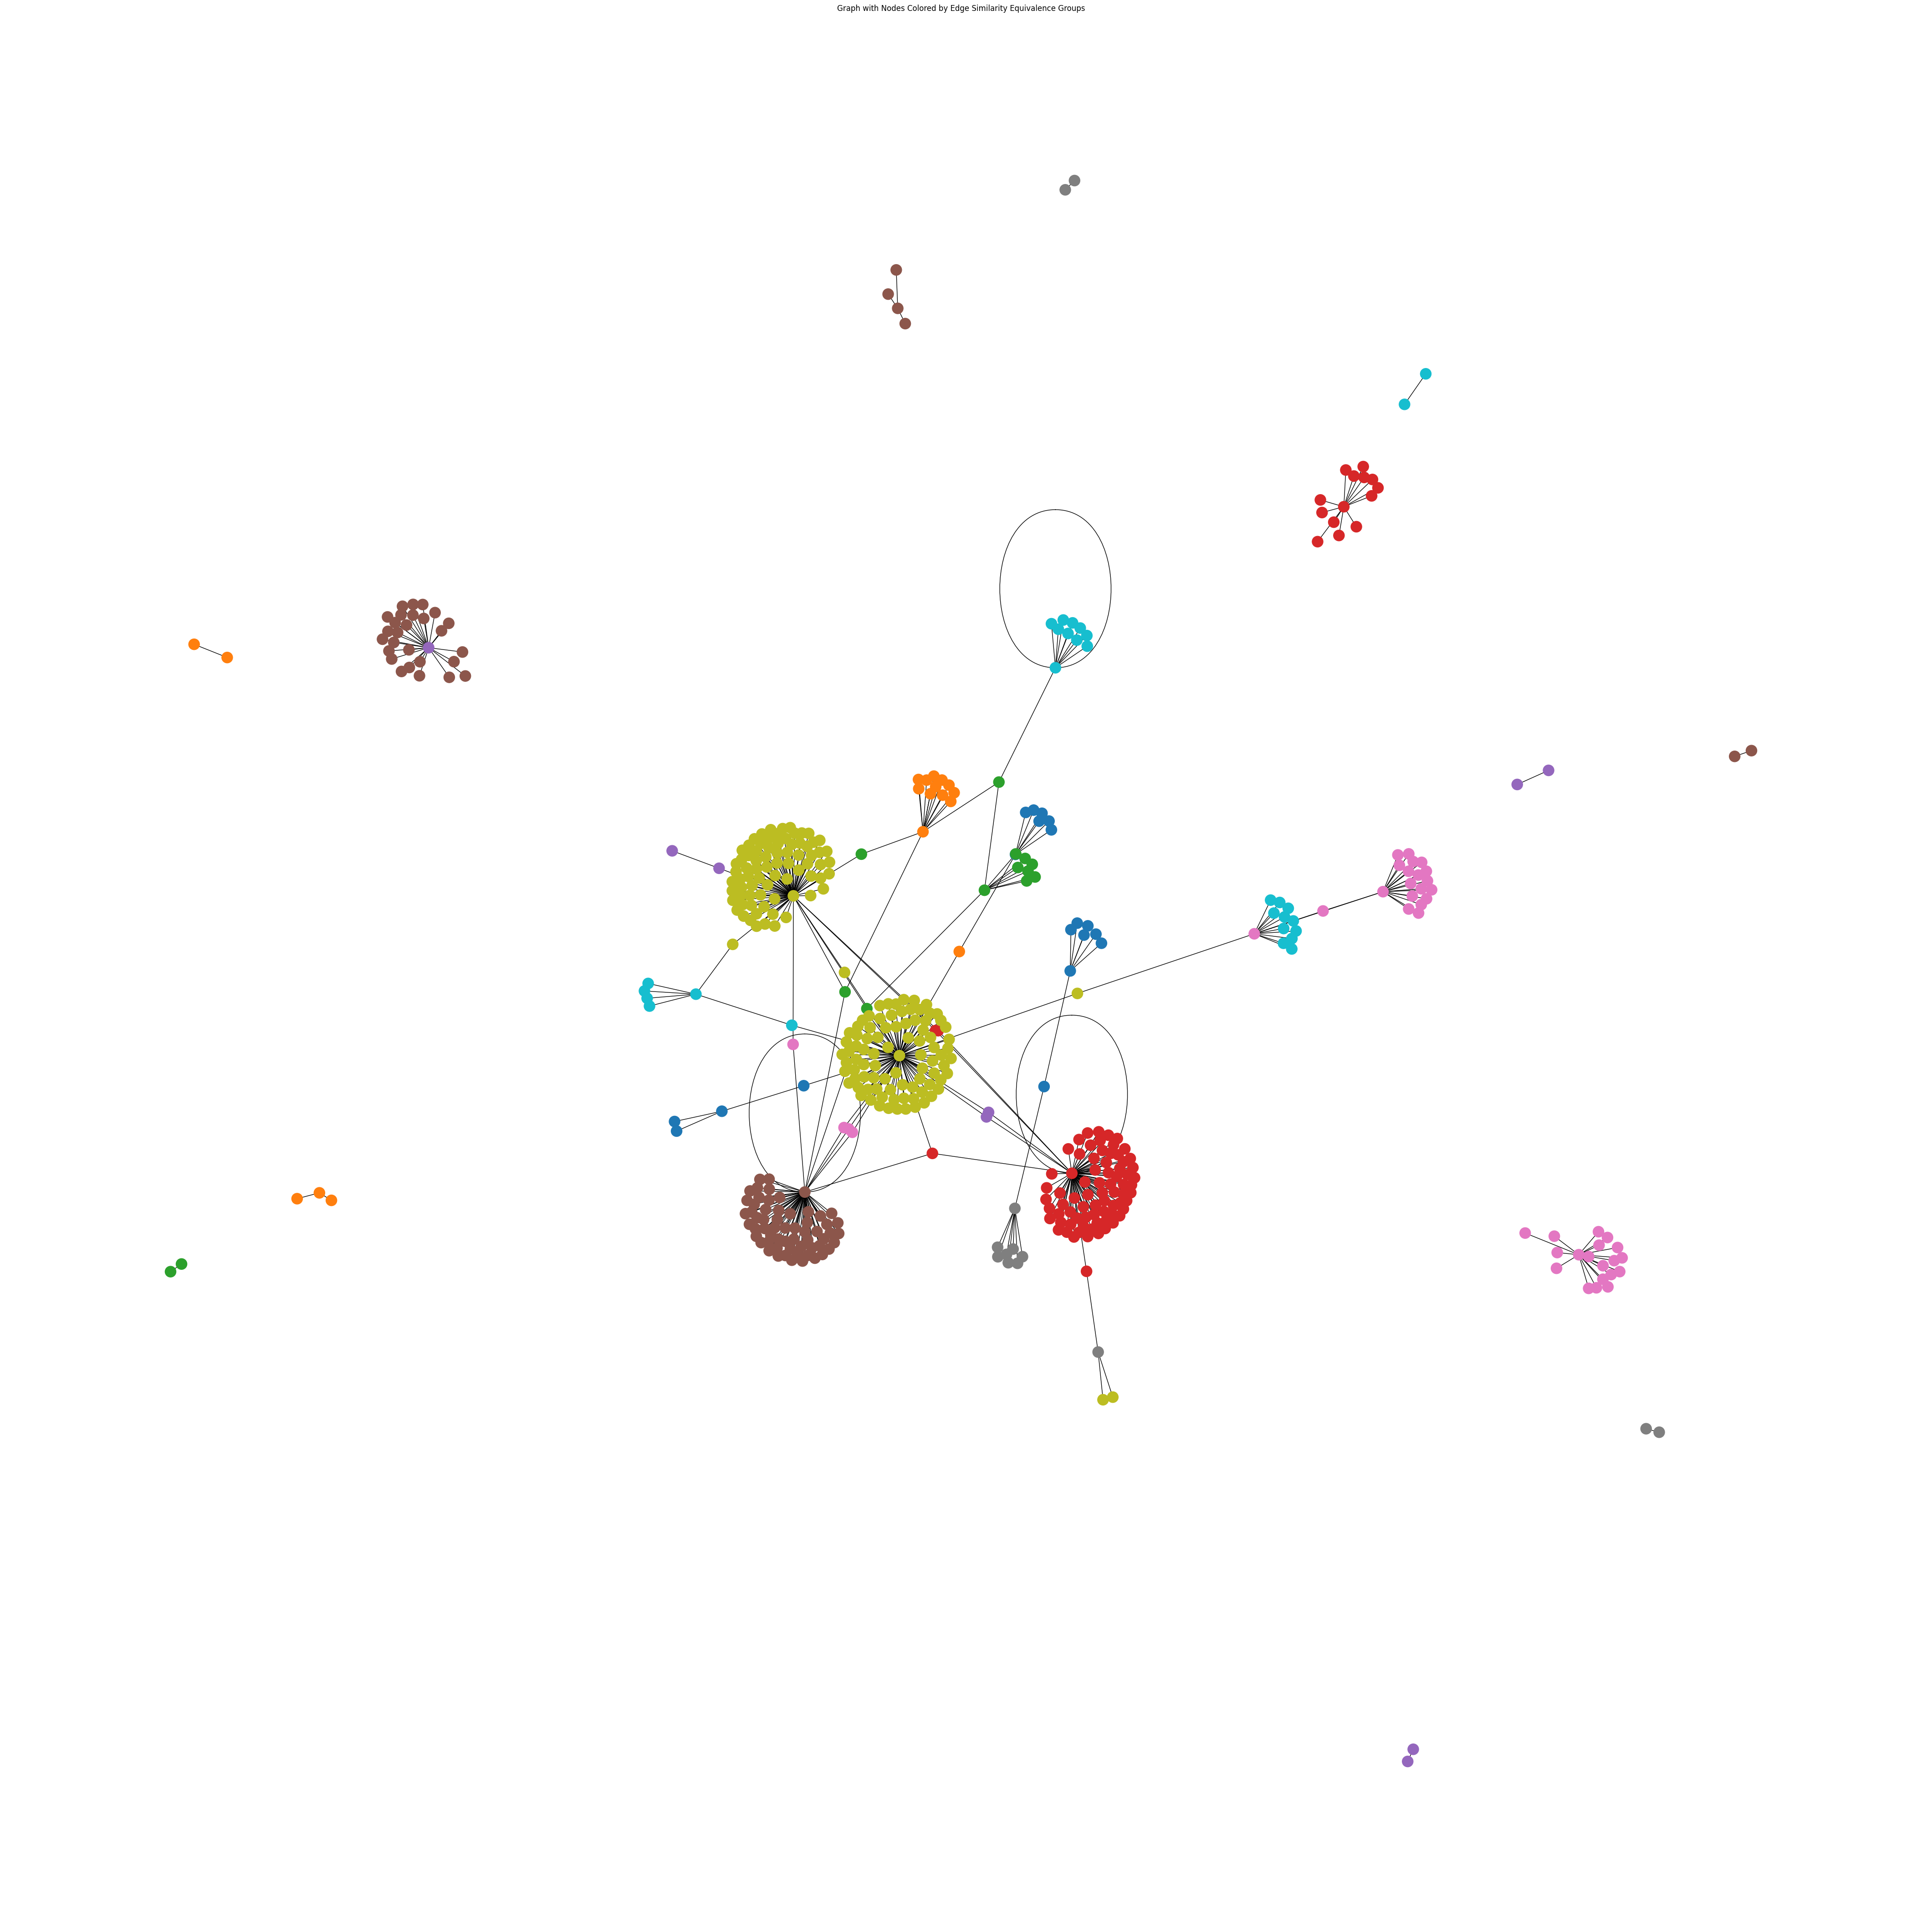

In [218]:
def find_edge_similarity_equivalent_nodes(graph):
    equivalent = []
    nodes = list(graph.nodes())
    while nodes:
        node = nodes[0]
        equivalent.append([node])
        neighbors = set(graph.neighbors(node))
        nodes.remove(node)
        i = 0
        while i < len(equivalent[-1]):
            curr_node = equivalent[-1][i]
            curr_neighbors = set(graph.neighbors(curr_node))
            for n in nodes[:]:
                if sorted(curr_neighbors) == sorted(set(graph.neighbors(n))):
                    equivalent[-1].append(n)
                    nodes.remove(n)
            i += 1
    return equivalent

# Find nodes with edge similarity equivalence
edge_similarity_equivalent_nodes = find_edge_similarity_equivalent_nodes(G)

# Create a color map for nodes based on edge similarity equivalence groups
color_map_edge = {}
for i, nodes in enumerate(edge_similarity_equivalent_nodes):
    for node in nodes:
        color_map_edge[node] = i

# Assign a default color for nodes not in any group
default_color_edge = len(edge_similarity_equivalent_nodes)
for node in G.nodes():
    if node not in color_map_edge:
        color_map_edge[node] = default_color_edge

# Positions of nodes for visualization
pos_edge = nx.spring_layout(G, seed=42)  # Positions of nodes for visualization

# Draw the graph with nodes colored by edge similarity equivalence groups
plt.figure(figsize=(42, 42))
node_colors_edge = [color_map_edge[node] for node in G.nodes()]
nx.draw(G, pos_edge, node_color=node_colors_edge, with_labels=False, cmap=plt.cm.tab10)
plt.title('Graph with Nodes Colored by Edge Similarity Equivalence Groups')
plt.show()


In [219]:
def find_automorphic_equivalent_nodes(graph):
    equivalent = []
    nodes = list(graph.nodes())
    while nodes:
        node = nodes[0]
        equivalent.append([node])
        mapping = {node: node}
        nodes.remove(node)
        i = 0
        while i < len(equivalent[-1]):
            curr_node = equivalent[-1][i]
            for n in nodes[:]:
                is_automorphic = True
                for edge in graph.edges(curr_node):
                    mapped_edge = (mapping[edge[0]], mapping[edge[1]])
                    if not graph.has_edge(n, mapped_edge[1]) or not graph.has_edge(mapped_edge[0], n):
                        is_automorphic = False
                        break
                if is_automorphic:
                    equivalent[-1].append(n)
                    mapping[n] = n
                    nodes.remove(n)
            i += 1
    return equivalent

# Find nodes with automorphic equivalence
automorphic_equivalent_nodes = find_automorphic_equivalent_nodes(G)

# Create a color map for nodes based on automorphic equivalence groups
color_map_automorphic = {}
for i, nodes in enumerate(automorphic_equivalent_nodes):
    for node in nodes:
        color_map_automorphic[node] = i

# Assign a default color for nodes not in any group
default_color_automorphic = len(automorphic_equivalent_nodes)
for node in G.nodes():
    if node not in color_map_automorphic:
        color_map_automorphic[node] = default_color_automorphic

# Positions of nodes for visualization
pos_automorphic = nx.spring_layout(G, seed=42)  # Positions of nodes for visualization

# Draw the graph with nodes colored by automorphic equivalence groups
plt.figure(figsize=(42, 42))
node_colors_automorphic = [color_map_automorphic[node] for node in G.nodes()]
nx.draw(G, pos_automorphic, node_color=node_colors_automorphic, with_labels=False, cmap=plt.cm.tab10)
plt.title('Graph with Nodes Colored by Automorphic Equivalence Groups')
plt.show()


KeyError: 30911.0

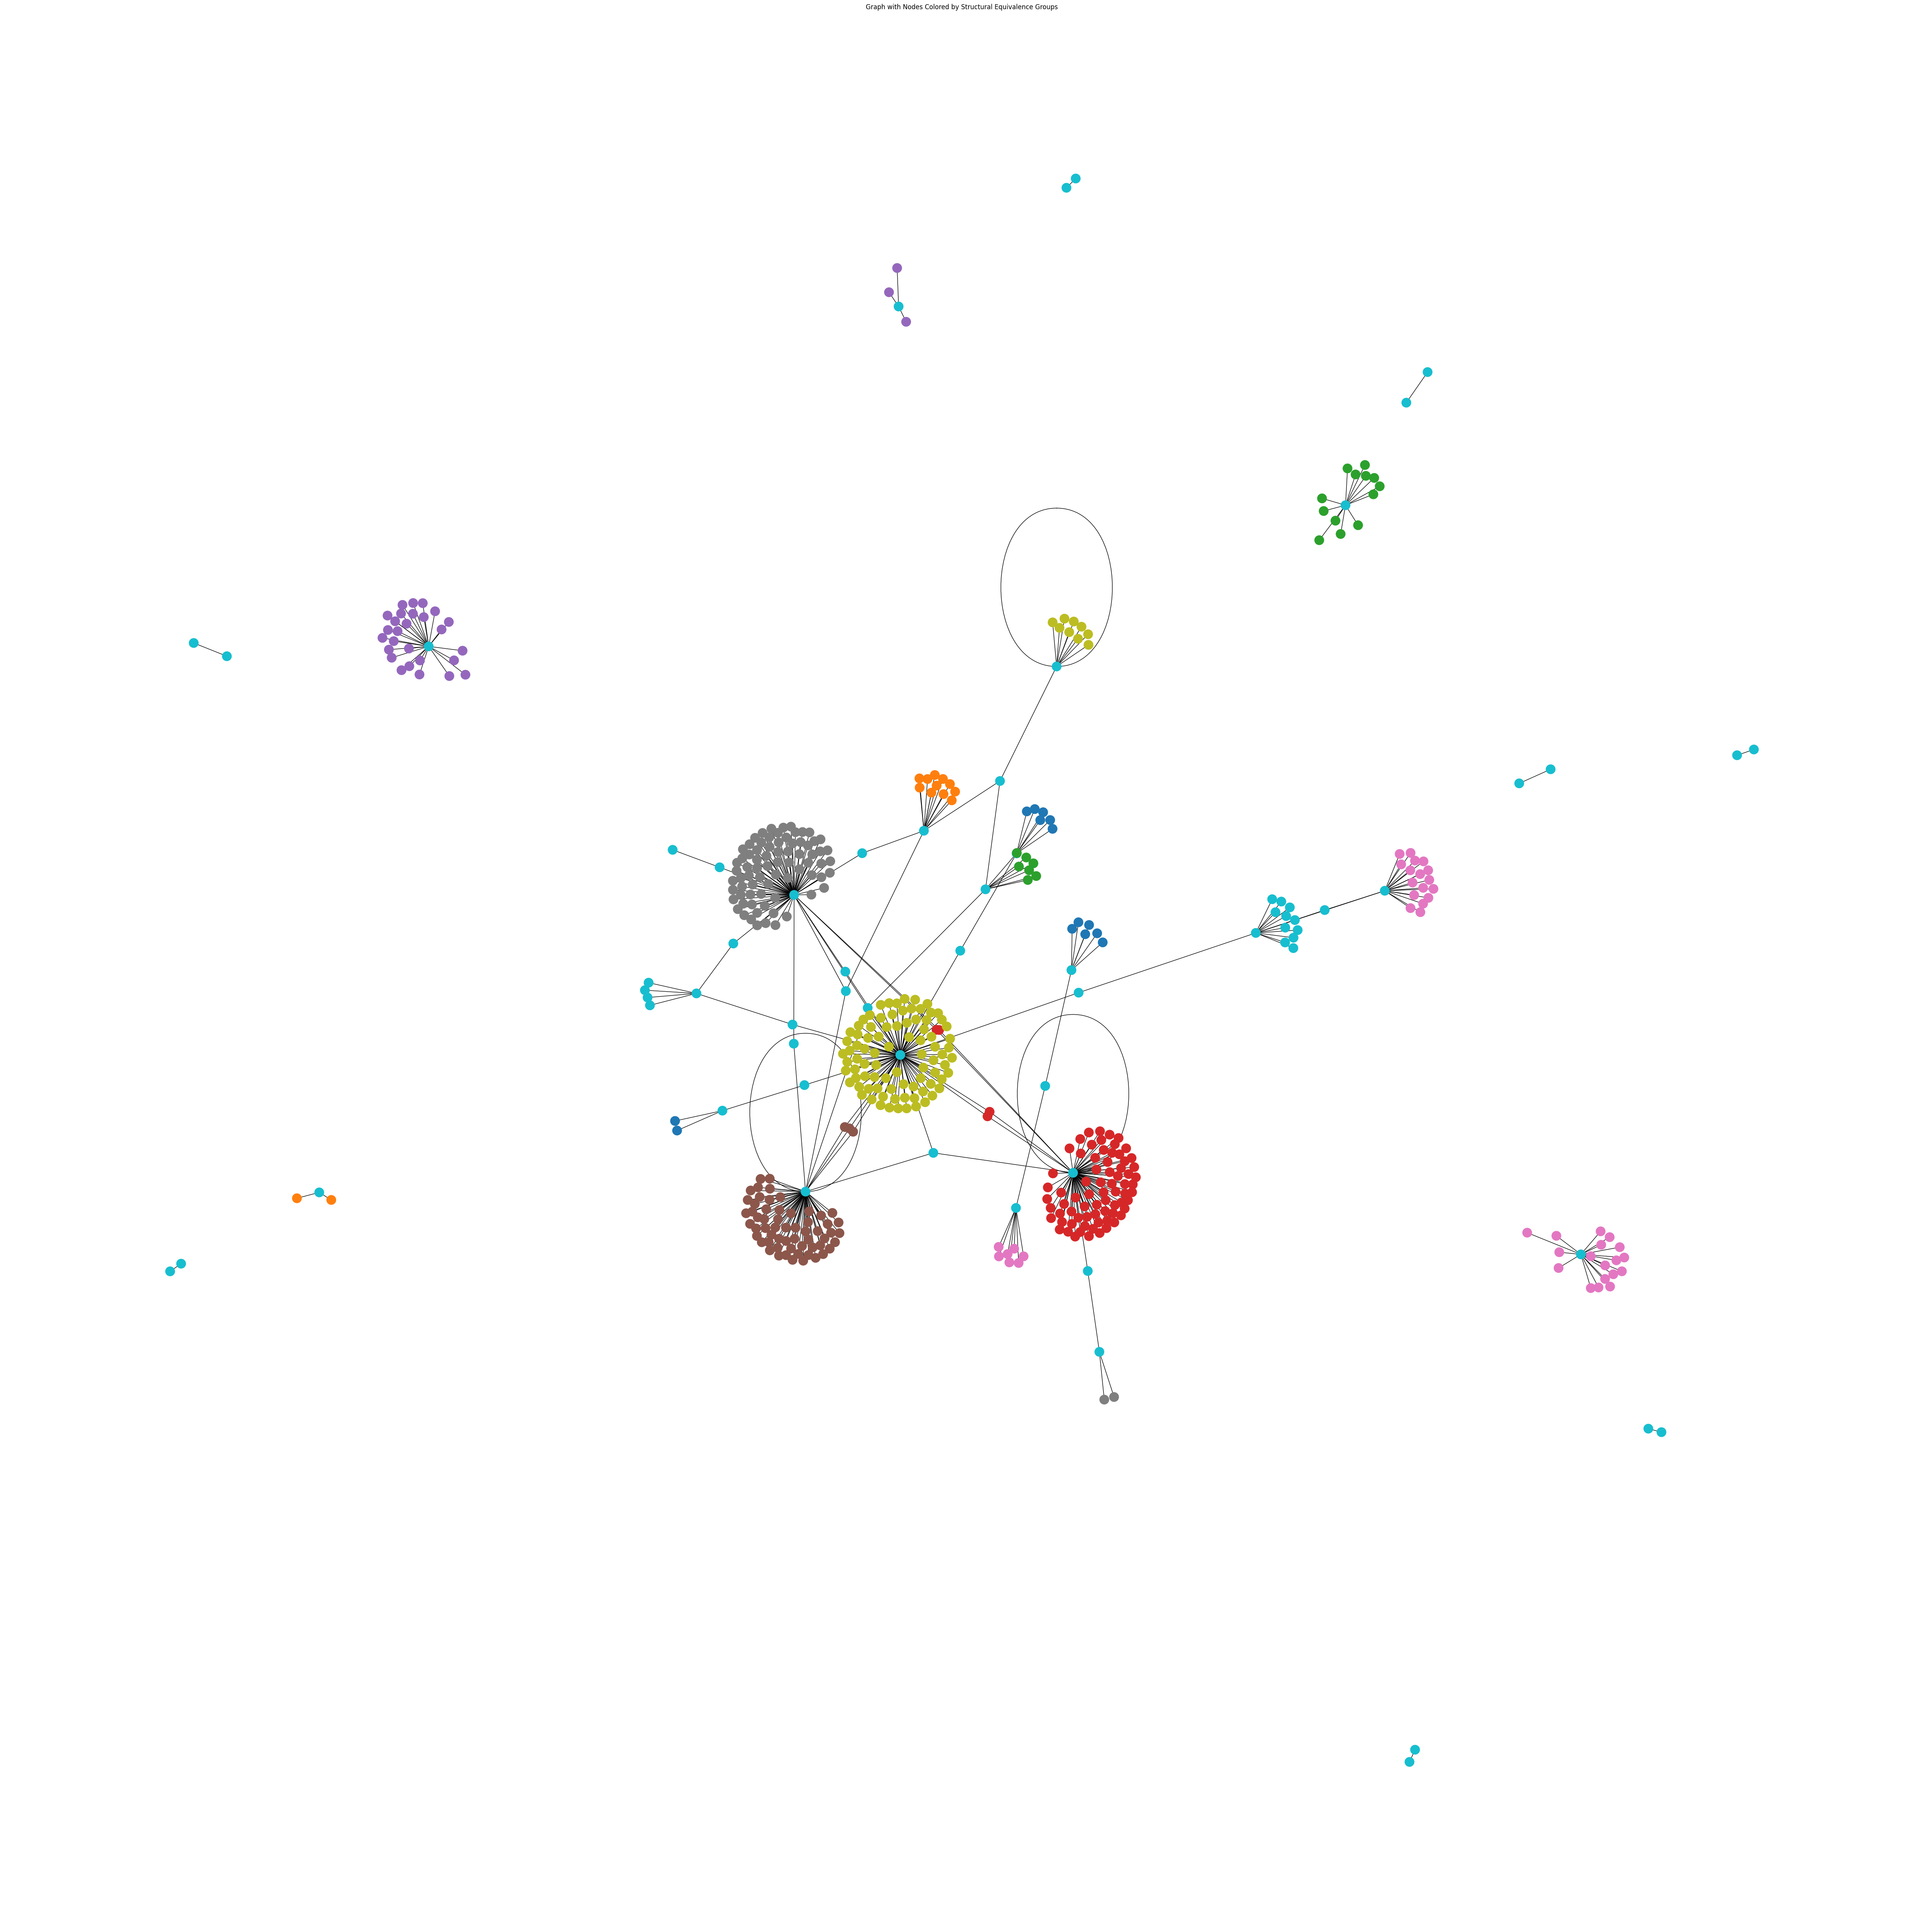

In [159]:
import networkx as nx
import matplotlib.pyplot as plt

def find_structurally_equivalent_nodes(graph):
    structurally_equivalent = []
    nodes = list(graph.nodes())
    while nodes:
        node = nodes[0]
        equivalent = [node]
        neighbors = set(graph.neighbors(node))
        nodes.remove(node)
        i = 0
        while i < len(equivalent):
            curr_node = equivalent[i]
            for n in nodes[:]:
                if neighbors == set(graph.neighbors(n)):
                    equivalent.append(n)
                    nodes.remove(n)
            i += 1
        if len(equivalent) > 1:
            structurally_equivalent.append(equivalent)
    return structurally_equivalent

# Find structurally equivalent nodes
structurally_equivalent_nodes = find_structurally_equivalent_nodes(G)

# Create a color map for nodes based on structural equivalence groups
color_map = {}
for i, nodes in enumerate(structurally_equivalent_nodes):
    for node in nodes:
        color_map[node] = i

# Assign a default color for nodes not in any group
default_color = len(structurally_equivalent_nodes)
for node in G.nodes():
    if node not in color_map:
        color_map[node] = default_color

# Positions of nodes for visualization
pos = nx.spring_layout(G, seed=42)  # Positions of nodes for visualization

# Set figure size
plt.figure(figsize=(50, 50))

# Draw the graph with nodes colored by structural equivalence groups
node_colors = [color_map[node] for node in G.nodes()]
nx.draw(G, pos, node_color=node_colors, with_labels=False, cmap=plt.cm.tab10)
plt.title('Graph with Nodes Colored by Structural Equivalence Groups')
plt.show()


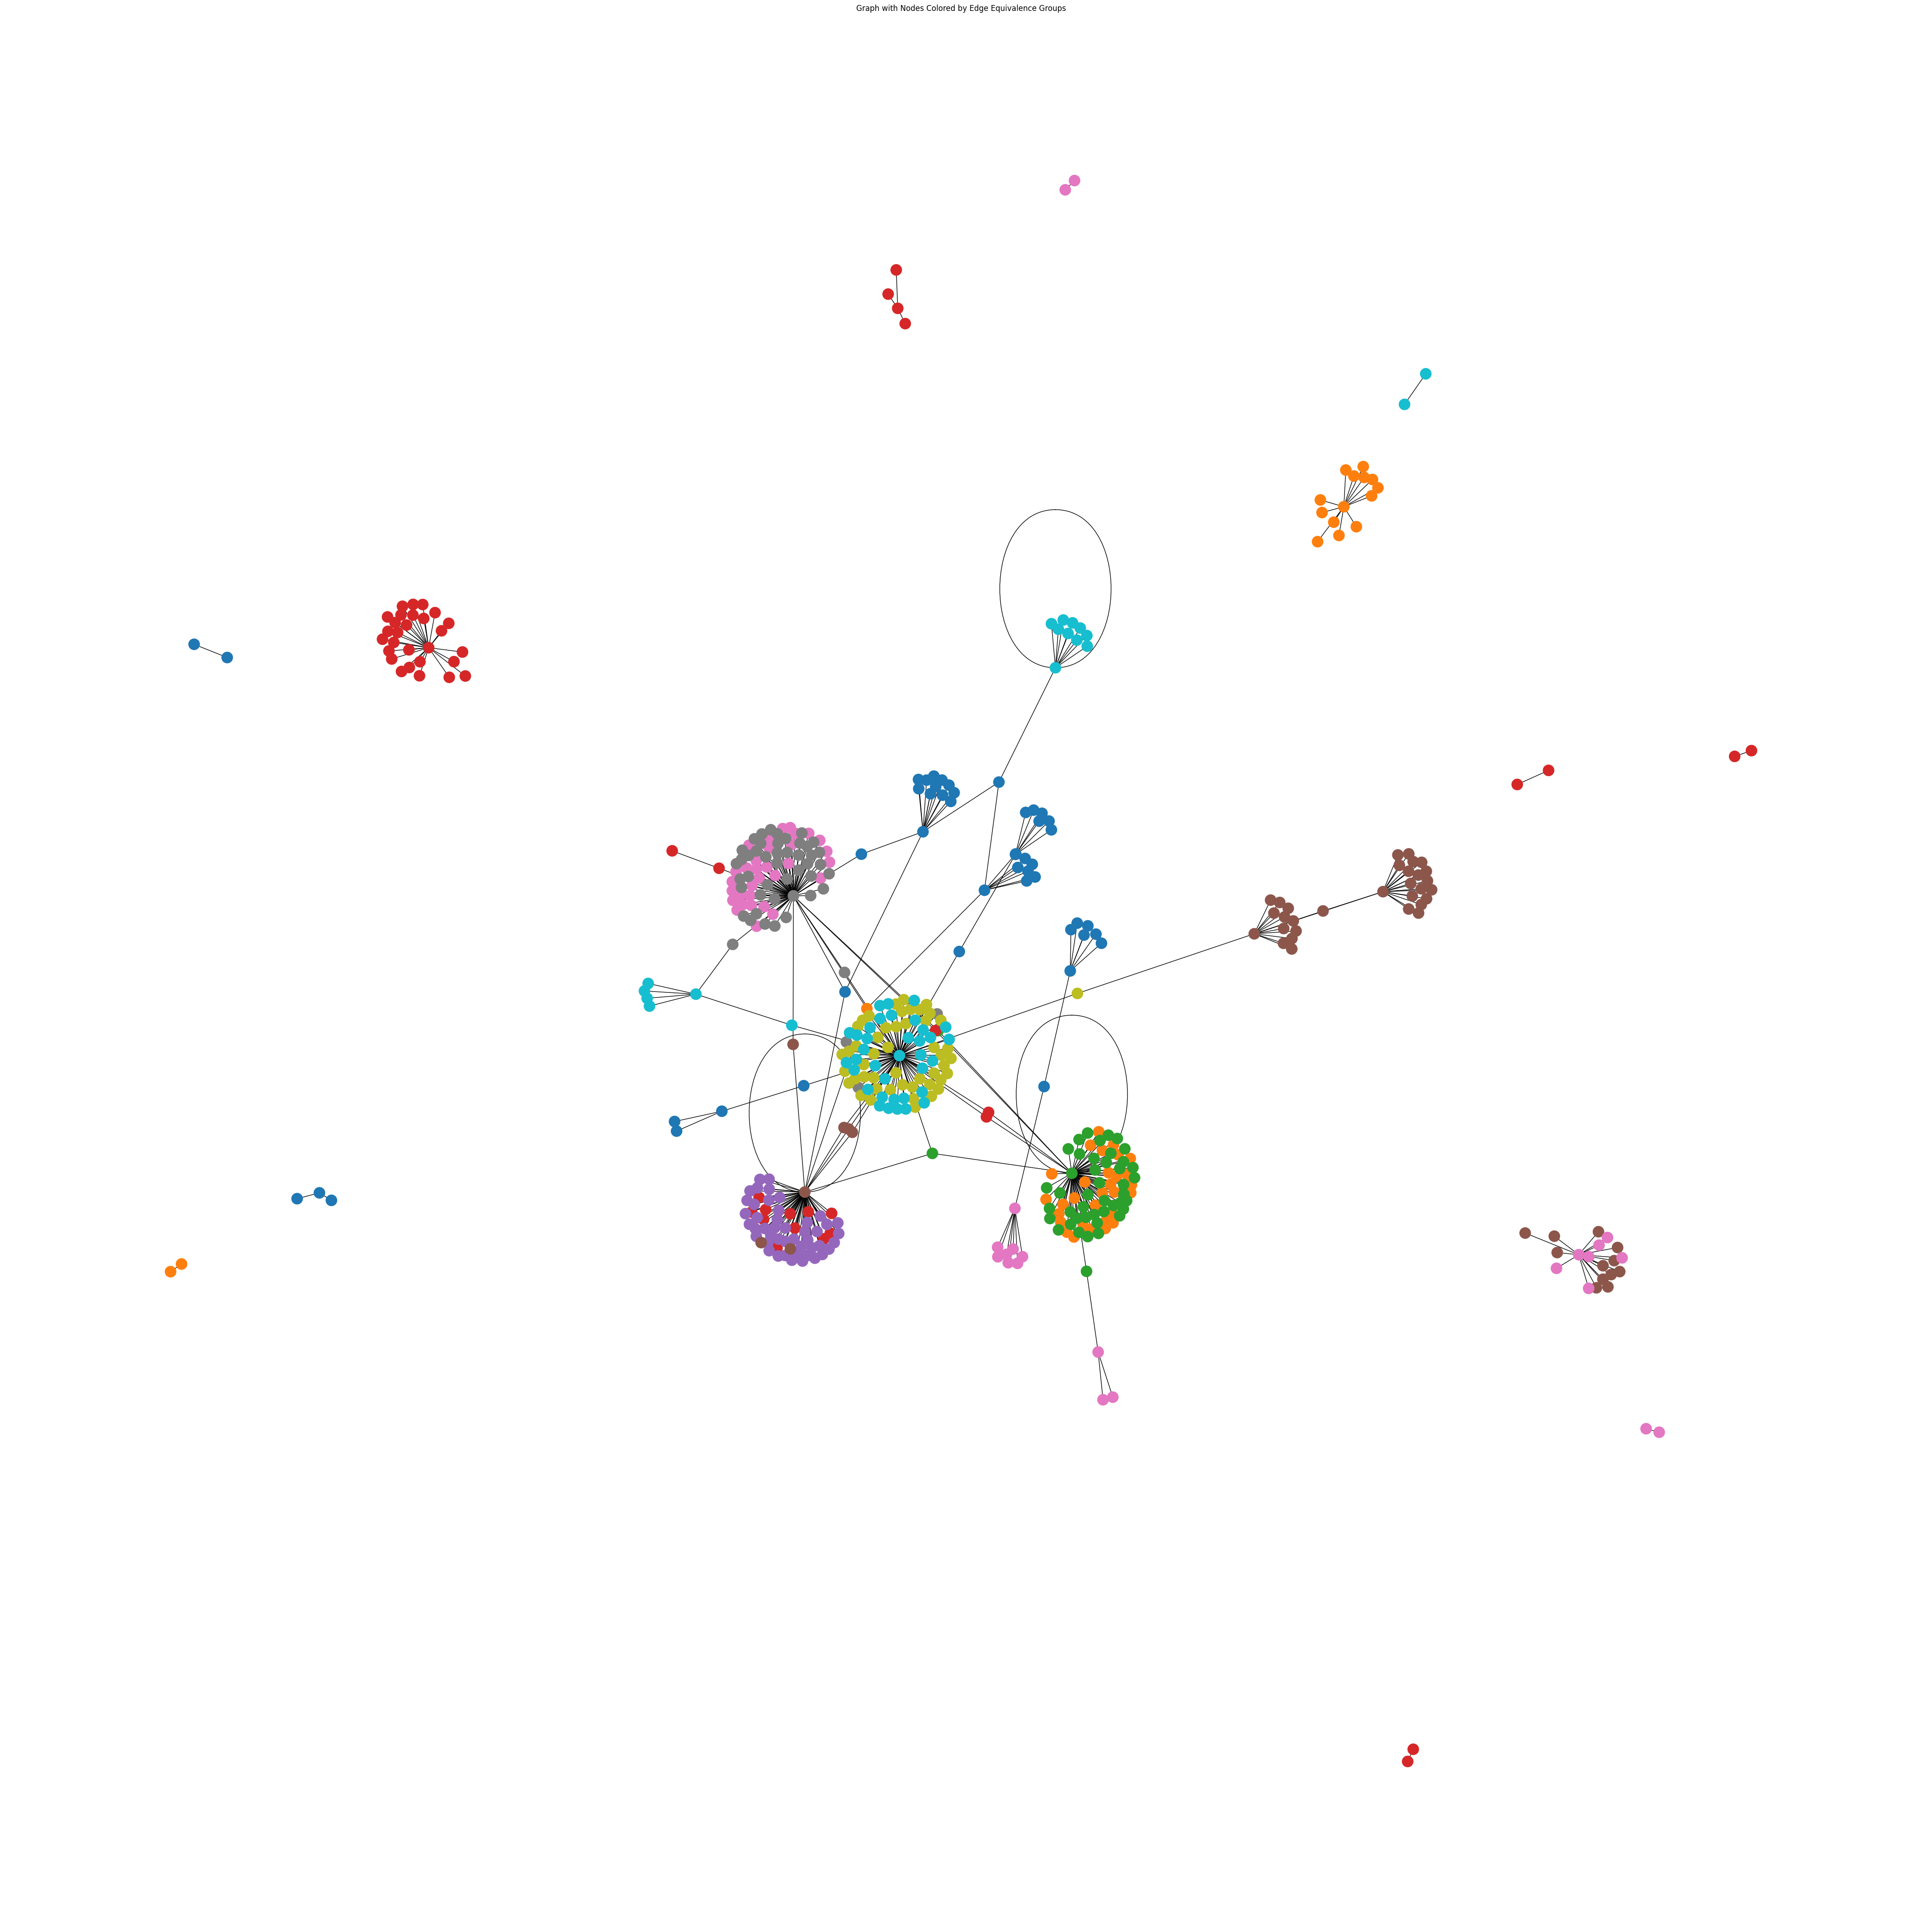

In [221]:
def find_edge_equivalent_nodes(graph):
    equivalent = []
    edges = list(graph.edges())
    while edges:
        edge = edges[0]
        equivalent.append([edge])
        nodes = set(edge)
        edges.remove(edge)
        i = 0
        while i < len(equivalent[-1]):
            curr_edge = equivalent[-1][i]
            for e in edges[:]:
                if set(e).intersection(nodes) == nodes:
                    equivalent[-1].append(e)
                    nodes.update(e)
                    edges.remove(e)
            i += 1
    return equivalent

# Find nodes with edge equivalence
edge_equivalent_nodes = find_edge_equivalent_nodes(G)

# Create a color map for nodes based on edge equivalence groups
color_map_edge = {}
for i, edges in enumerate(edge_equivalent_nodes):
    for edge in edges:
        for node in edge:
            color_map_edge[node] = i

# Assign a default color for nodes not in any group
default_color_edge = len(edge_equivalent_nodes)
for node in G.nodes():
    if node not in color_map_edge:
        color_map_edge[node] = default_color_edge

# Positions of nodes for visualization
pos_edge = nx.spring_layout(G, seed=42)  # Positions of nodes for visualization

# Draw the graph with nodes colored by edge equivalence groups
plt.figure(figsize=(42, 42))
node_colors_edge = [color_map_edge[node] for node in G.nodes()]
nx.draw(G, pos_edge, node_color=node_colors_edge, with_labels=False, cmap=plt.cm.tab10)
plt.title('Graph with Nodes Colored by Edge Equivalence Groups')
plt.show()


In [164]:
import networkx as nx

# Define a function to calculate dissimilarity between nodes based on edge presence
def calculate_dissimilarity(graph, node1, node2):
    if graph.has_edge(node1, node2):
        return 0  # Nodes connected by an edge, they are similar
    else:
        return 1  # Nodes not connected by an edge, they are dissimilar

# Create a graph (you can define your own graph here)
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4, 5])
G.add_edges_from([(1, 2), (1, 3), (2, 3), (4, 5)])

# Calculate dissimilarity between nodes based on edge presence
nodes = list(G.nodes())
dissimilarities = {}
for node1 in nodes:
    for node2 in nodes:
        if node1 != node2 and (node2, node1) not in dissimilarities:
            dissimilarity = calculate_dissimilarity(G, node1, node2)
            dissimilarities[(node1, node2)] = dissimilarity
            dissimilarities[(node2, node1)] = dissimilarity  # Since Qij = Qji

# Display the dissimilarities
print("Dissimilarities based on edge presence:")
for nodes, dissimilarity in dissimilarities.items():
    print(f"D({nodes[0]}, {nodes[1]}) = {dissimilarity}")


Dissimilarities based on edge presence:
D(1, 2) = 0
D(2, 1) = 0
D(1, 3) = 0
D(3, 1) = 0
D(1, 4) = 1
D(4, 1) = 1
D(1, 5) = 1
D(5, 1) = 1
D(2, 3) = 0
D(3, 2) = 0
D(2, 4) = 1
D(4, 2) = 1
D(2, 5) = 1
D(5, 2) = 1
D(3, 4) = 1
D(4, 3) = 1
D(3, 5) = 1
D(5, 3) = 1
D(4, 5) = 0
D(5, 4) = 0


In [171]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster

# Example adjacency matrix (replace this with your adjacency matrix)
adj_matrix = np.array([
    [0, 1, 1, 0],
    [1, 0, 1, 0],
    [1, 1, 0, 1],
    [0, 0, 1, 0]
])

# Perform hierarchical clustering
Z = linkage(adj_matrix, 'ward')  # Using Ward's method for clustering

# Determine clusters using a chosen criterion (e.g., maxclust or distance threshold)
max_clusters = 2  # Define the number of clusters
clusters = fcluster(Z, max_clusters, criterion='maxclust')

# Rearrange adjacency matrix based on clusters
def rearrange_matrix(adj_matrix, clusters):
    num_nodes = len(adj_matrix)
    rearranged_matrix = np.zeros((num_nodes, num_nodes))

    # Sort nodes based on their assigned clusters
    node_order = np.argsort(clusters)

    # Rearrange adjacency matrix based on node order
    for i in range(num_nodes):
        for j in range(num_nodes):
            rearranged_matrix[i][j] = adj_matrix[node_order[i]][node_order[j]]

    return rearranged_matrix

# Create the rearranged adjacency matrix based on clusters
rearranged_adj_matrix = rearrange_matrix(adj_matrix, clusters)

# Display the rearranged adjacency matrix
print("Rearranged Adjacency Matrix based on Clusters:")
print(rearranged_adj_matrix)


Rearranged Adjacency Matrix based on Clusters:
[[0. 1. 0. 1.]
 [1. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 1. 1. 0.]]


/tmp/ipykernel_6424/2556061332.py:13: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



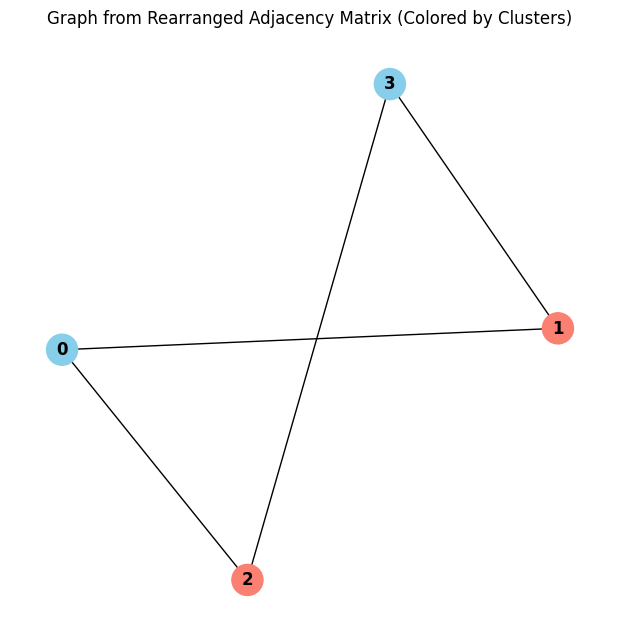

In [174]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Rearranged adjacency matrix (replace this with your rearranged matrix)
rearranged_adj_matrix = np.array([
    [0, 1, 1, 0],
    [1, 0, 0, 1],
    [1, 0, 0, 1],
    [0, 1, 1, 0]
])

# Example cluster assignments (replace this with your actual clusters)
cluster_assignments = [0, 1, 1, 0]  # Example: clusters assigned as 0 and 1

# Create a graph from the rearranged adjacency matrix
G = nx.Graph()

num_nodes = len(rearranged_adj_matrix)
for i in range(num_nodes):
    for j in range(num_nodes):
        if rearranged_adj_matrix[i][j] == 1:
            G.add_edge(i, j)

# Define colors for nodes based on clusters
colors = ['skyblue' if cluster_assignments[node] == 0 else 'salmon' for node in G.nodes()]

# Define positions for better visualization
pos = nx.spring_layout(G)

# Draw the graph with nodes colored by clusters
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_size=500, font_weight='bold', node_color=colors, edge_color='black')
plt.title('Graph from Rearranged Adjacency Matrix (Colored by Clusters)')
plt.show()
